✅ Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Sahil\.cache\huggingface\hub\models--timm--efficientnet_b3.ra2_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight,

Epoch 1/3 - Train Loss: 0.8377
                precision    recall  f1-score   support

         No_DR     0.9417    0.9883    0.9644       343
          Mild     0.6567    0.5714    0.6111        77
      Moderate     0.8050    0.5899    0.6809       217
        Severe     1.0000    0.0263    0.0513        38
Proliferate_DR     0.3219    0.8103    0.4608        58

      accuracy                         0.7626       733
     macro avg     0.7451    0.5973    0.5537       733
  weighted avg     0.8253    0.7626    0.7562       733

Epoch 2/3 - Train Loss: 0.5507
                precision    recall  f1-score   support

         No_DR     0.9913    0.9913    0.9913       343
          Mild     0.5577    0.7532    0.6409        77
      Moderate     0.7767    0.7696    0.7731       217
        Severe     0.8000    0.1053    0.1860        38
Proliferate_DR     0.5758    0.6552    0.6129        58

      accuracy                         0.8281       733
     macro avg     0.7403    0.6549  

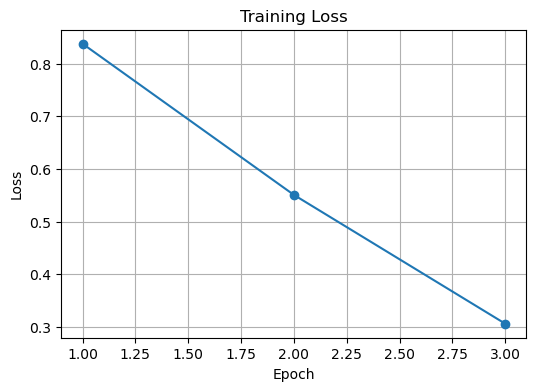


Final Classification Report:
                precision    recall  f1-score   support

         No_DR     0.9771    0.9971    0.9870       343
          Mild     0.6912    0.6104    0.6483        77
      Moderate     0.7657    0.8433    0.8026       217
        Severe     0.5111    0.6053    0.5542        38
Proliferate_DR     0.8065    0.4310    0.5618        58

      accuracy                         0.8458       733
     macro avg     0.7503    0.6974    0.7108       733
  weighted avg     0.8468    0.8458    0.8408       733



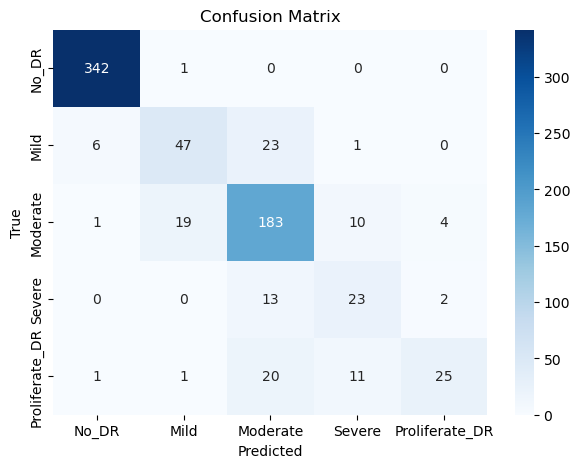

In [3]:
# ===============================================================
#  EfficientNet + CBAM (fixed) + Distillation + Scheduler
# ===============================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import numpy as np

# -------------------------
# Check Device (GPU)
# -------------------------
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"✅ Using GPU: {device_name}")
else:
    print("⚠️ No NVIDIA GPU found. Using CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Dataset
# -------------------------
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, img_exts=(".png", ".jpg", ".jpeg")):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform
        self.data.columns = [c.strip().lower() for c in self.data.columns]
        self.image_col = self.data.columns[0]
        self.label_col = self.data.columns[1]
        self.folder_names = sorted([f for f in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, f))])
        self.numeric_to_folder = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}
        self.img_exts = img_exts

    def __len__(self):
        return len(self.data)

    def _find_image(self, folder, img_id):
        for ext in self.img_exts:
            p = os.path.join(self.img_root, folder, f"{img_id}{ext}")
            if os.path.exists(p):
                return p
        # fallback
        p = os.path.join(self.img_root, folder, img_id)
        if os.path.exists(p):
            return p
        raise FileNotFoundError(f"Image for id {img_id} not found in {folder}")

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx][self.image_col])
        label_val = self.data.iloc[idx][self.label_col]
        if isinstance(label_val, (int, float)) or str(label_val).isdigit():
            label_val = int(label_val)
            folder_name = self.numeric_to_folder[label_val]
            label_idx = label_val
        else:
            folder_name = str(label_val)
            label_idx = self.folder_names.index(folder_name)
        img_path = self._find_image(folder_name, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# -------------------------
# CBAM (Channel + Spatial)
# -------------------------
class ChannelGate(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False)
        )

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = torch.mean(x, dim=(2, 3))
        max_pool, _ = torch.max(x.view(b, c, -1), dim=2)
        out = self.mlp(avg_pool) + self.mlp(max_pool)
        return torch.sigmoid(out).view(b, c, 1, 1)

class SpatialGate(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, mx], dim=1)
        out = self.bn(self.conv(cat))
        return torch.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_gate = ChannelGate(channels, reduction)
        self.spatial_gate = SpatialGate(kernel_size)

    def forward(self, x):
        x = x * self.channel_gate(x)
        x = x * self.spatial_gate(x)
        return x

# -------------------------
# Model
# -------------------------
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', num_classes=5, use_cbam=True, pretrained=True):
        super().__init__()
        self.feature_extractor = timm.create_model(backbone_name, pretrained=pretrained, features_only=True)
        out_channels = self.feature_extractor.feature_info[-1]['num_chs']
        self.use_cbam = use_cbam
        self.cbam = CBAMBlock(out_channels) if use_cbam else None
        self.classifier = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if isinstance(feats, (list, tuple)):
            feats = feats[-1]
        if feats.dim() != 4:
            raise RuntimeError(f"Expected 4D feature map, got {feats.shape}")
        if self.cbam:
            feats = self.cbam(feats)
        pooled = nn.functional.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)
        logits = self.classifier(pooled)
        return logits

# -------------------------
# Distillation Loss
# -------------------------
class DistillationLoss(nn.Module):
    def __init__(self, base_loss, teacher_model, alpha=0.5, temperature=4.0):
        super().__init__()
        self.base_loss = base_loss
        self.teacher = teacher_model
        self.alpha = alpha
        self.T = temperature
        if self.teacher is not None:
            self.teacher.eval()
            for p in self.teacher.parameters():
                p.requires_grad = False

    def forward(self, student_logits, inputs, labels):
        hard = self.base_loss(student_logits, labels)
        if self.teacher is None:
            return hard
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)
        s_logp = nn.functional.log_softmax(student_logits / self.T, dim=1)
        t_prob = nn.functional.softmax(teacher_logits / self.T, dim=1)
        soft = nn.KLDivLoss(reduction='batchmean')(s_logp, t_prob) * (self.T * self.T)
        return self.alpha * soft + (1.0 - self.alpha) * hard

# -------------------------
# Trainer
# -------------------------
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train_epoch(self, loader, epoch_idx=0):
        self.model.train()
        running_loss = 0.0
        n = 0
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.criterion(outputs, imgs, labels) if isinstance(self.criterion, DistillationLoss) else self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            if self.scheduler is not None:
                self.scheduler.step()
            running_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
        return running_loss / max(1, n)

    def evaluate(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                preds.extend(outputs.argmax(1).cpu().numpy().tolist())
                trues.extend(labels.numpy().tolist())
        return preds, trues

# -------------------------
# CONFIG
# -------------------------
config = {
    "csv_path": "train.csv",
    "img_root": "colored_images",
    "backbone": "efficientnet_b3",
    "num_classes": 5,
    "batch_size": 8,
    "epochs": 3,
    "lr": 1e-4,
    "use_cbam": True,
    "use_distill": False,
    "teacher_backbone": "efficientnet_b5"
}

# -------------------------
# Data
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = RetinopathyDataset(config["csv_path"], config["img_root"], transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False)

# -------------------------
# Model, Loss, Optimizer, Scheduler
# -------------------------
teacher_model = None
if config["use_distill"]:
    teacher_model = timm.create_model(config["teacher_backbone"], pretrained=True, num_classes=config["num_classes"])
    teacher_model = teacher_model.to(device).eval()

model = EfficientNetWithCBAM(config["backbone"], config["num_classes"], config["use_cbam"], pretrained=True).to(device)

base_loss = nn.CrossEntropyLoss()
criterion = DistillationLoss(base_loss, teacher_model) if config["use_distill"] else base_loss

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config["lr"] * 10,
    steps_per_epoch=len(train_loader),
    epochs=config["epochs"]
)

trainer = Trainer(model, criterion, optimizer, scheduler, device)

# -------------------------
# Training loop
# -------------------------
train_losses = []
for epoch in range(config["epochs"]):
    loss = trainer.train_epoch(train_loader, epoch)
    train_losses.append(loss)
    print(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {loss:.4f}")
    preds, trues = trainer.evaluate(val_loader)
    print(classification_report(trues, preds, digits=4,
          target_names=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]))

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

preds, trues = trainer.evaluate(val_loader)
print("\nFinal Classification Report:")
print(classification_report(trues, preds, digits=4,
      target_names=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"],
            yticklabels=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# ===============================================================
#  EfficientNet + CBAM (fixed) + Distillation + Scheduler + Grad-CAM
# ===============================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import numpy as np
import random
import cv2
from torchcam.methods import GradCAM
from torchvision.utils import save_image

# -------------------------
# Check Device (GPU)
# -------------------------
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    if "NVIDIA" in device_name.upper():
        print(f"✅ Using NVIDIA GPU: {device_name}")
    else:
        print(f"⚠️ Using non-NVIDIA GPU: {device_name}")
else:
    print("⚠️ No GPU found. Using CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Dataset
# -------------------------
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, img_exts=(".png", ".jpg", ".jpeg")):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform
        self.data.columns = [c.strip().lower() for c in self.data.columns]
        self.image_col = self.data.columns[0]
        self.label_col = self.data.columns[1]
        self.folder_names = sorted([f for f in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, f))])
        self.numeric_to_folder = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}
        self.img_exts = img_exts

    def __len__(self):
        return len(self.data)

    def _find_image(self, folder, img_id):
        for ext in self.img_exts:
            p = os.path.join(self.img_root, folder, f"{img_id}{ext}")
            if os.path.exists(p):
                return p
        p = os.path.join(self.img_root, folder, img_id)
        if os.path.exists(p):
            return p
        raise FileNotFoundError(f"Image for id {img_id} not found in {folder}")

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx][self.image_col])
        label_val = self.data.iloc[idx][self.label_col]
        if isinstance(label_val, (int, float)) or str(label_val).isdigit():
            label_val = int(label_val)
            folder_name = self.numeric_to_folder[label_val]
            label_idx = label_val
        else:
            folder_name = str(label_val)
            label_idx = self.folder_names.index(folder_name)
        img_path = self._find_image(folder_name, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# -------------------------
# CBAM (Channel + Spatial)
# -------------------------
class ChannelGate(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False)
        )

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = torch.mean(x, dim=(2, 3))
        max_pool, _ = torch.max(x.view(b, c, -1), dim=2)
        out = self.mlp(avg_pool) + self.mlp(max_pool)
        return torch.sigmoid(out).view(b, c, 1, 1)

class SpatialGate(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, mx], dim=1)
        out = self.bn(self.conv(cat))
        return torch.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_gate = ChannelGate(channels, reduction)
        self.spatial_gate = SpatialGate(kernel_size)

    def forward(self, x):
        x = x * self.channel_gate(x)
        x = x * self.spatial_gate(x)
        return x

# -------------------------
# Model
# -------------------------
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', num_classes=5, use_cbam=True, pretrained=True):
        super().__init__()
        self.feature_extractor = timm.create_model(backbone_name, pretrained=pretrained, features_only=True)
        out_channels = self.feature_extractor.feature_info[-1]['num_chs']
        self.use_cbam = use_cbam
        self.cbam = CBAMBlock(out_channels) if use_cbam else None
        self.classifier = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if isinstance(feats, (list, tuple)):
            feats = feats[-1]
        if feats.dim() != 4:
            raise RuntimeError(f"Expected 4D feature map, got {feats.shape}")
        if self.cbam:
            feats = self.cbam(feats)
        pooled = nn.functional.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)
        logits = self.classifier(pooled)
        return logits

# -------------------------
# Distillation Loss
# -------------------------
class DistillationLoss(nn.Module):
    def __init__(self, base_loss, teacher_model, alpha=0.5, temperature=4.0):
        super().__init__()
        self.base_loss = base_loss
        self.teacher = teacher_model
        self.alpha = alpha
        self.T = temperature
        if self.teacher is not None:
            self.teacher.eval()
            for p in self.teacher.parameters():
                p.requires_grad = False

    def forward(self, student_logits, inputs, labels):
        hard = self.base_loss(student_logits, labels)
        if self.teacher is None:
            return hard
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)
        s_logp = nn.functional.log_softmax(student_logits / self.T, dim=1)
        t_prob = nn.functional.softmax(teacher_logits / self.T, dim=1)
        soft = nn.KLDivLoss(reduction='batchmean')(s_logp, t_prob) * (self.T * self.T)
        return self.alpha * soft + (1.0 - self.alpha) * hard

# -------------------------
# Trainer
# -------------------------
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train_epoch(self, loader, epoch_idx=0):
        self.model.train()
        running_loss = 0.0
        n = 0
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.criterion(outputs, imgs, labels) if isinstance(self.criterion, DistillationLoss) else self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            if self.scheduler is not None:
                self.scheduler.step()
            running_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
        return running_loss / max(1, n)

    def evaluate(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                preds.extend(outputs.argmax(1).cpu().numpy().tolist())
                trues.extend(labels.numpy().tolist())
        return preds, trues

# -------------------------
# CONFIG
# -------------------------
config = {
    "csv_path": "train.csv",
    "img_root": "colored_images",
    "backbone": "efficientnet_b3",
    "num_classes": 5,
    "batch_size": 8,
    "epochs": 3,
    "lr": 1e-4,
    "use_cbam": True,
    "use_distill": False,
    "teacher_backbone": "efficientnet_b5",
    "loss_fn": "CrossEntropyLoss"  
}

# -------------------------
# Data
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = RetinopathyDataset(config["csv_path"], config["img_root"], transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False)

# -------------------------
# Model, Loss, Optimizer, Scheduler
# -------------------------
teacher_model = None
if config["use_distill"]:
    teacher_model = timm.create_model(config["teacher_backbone"], pretrained=True, num_classes=config["num_classes"])
    teacher_model = teacher_model.to(device).eval()

model = EfficientNetWithCBAM(config["backbone"], config["num_classes"], config["use_cbam"], pretrained=True).to(device)

# Select loss function from config
if config["loss_fn"].lower() == "crossentropyloss":
    base_loss = nn.CrossEntropyLoss()
elif config["loss_fn"].lower() == "mse":
    base_loss = nn.MSELoss()
else:
    raise ValueError(f"Unknown loss function: {config['loss_fn']}")

criterion = DistillationLoss(base_loss, teacher_model) if config["use_distill"] else base_loss

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config["lr"] * 10,
    steps_per_epoch=len(train_loader),
    epochs=config["epochs"]
)

trainer = Trainer(model, criterion, optimizer, scheduler, device)

# -------------------------
# Training loop
# -------------------------
train_losses = []
for epoch in range(config["epochs"]):
    loss = trainer.train_epoch(train_loader, epoch)
    train_losses.append(loss)
    print(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {loss:.4f}")
    preds, trues = trainer.evaluate(val_loader)
    print(classification_report(trues, preds, digits=4,
          target_names=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]))

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

preds, trues = trainer.evaluate(val_loader)
print("\nFinal Classification Report:")
print(classification_report(trues, preds, digits=4,
      target_names=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"],
            yticklabels=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------
# Grad-CAM Visualization (one random image per class)
# -------------------------
os.makedirs("Grad_Cam", exist_ok=True)
model.eval()
cam_extractor = GradCAM(model, target_layer=model.classifier)

print("\nGenerating Grad-CAMs for 5 random images (one from each class)...")

indices_per_class = {i: [] for i in range(config["num_classes"])}
for i in range(len(dataset)):
    _, label = dataset[i]
    indices_per_class[label].append(i)

for cls_idx, cls_name in enumerate(["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]):
    if len(indices_per_class[cls_idx]) == 0:
        continue
    idx = random.choice(indices_per_class[cls_idx])
    img, _ = dataset[idx]
    img_input = img.unsqueeze(0).to(device)
    out = model(img_input)
    pred_class = out.argmax(dim=1).item()

    cam_map = cam_extractor(pred_class, out)[0].cpu()
    cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min())
    cam_map = cv2.resize(cam_map.numpy(), (224, 224))

    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    overlay = np.uint8(255 * img_np)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
    blended = cv2.addWeighted(overlay, 0.5, heatmap, 0.5, 0)

    out_path = f"Grad_Cam/{cls_name}_gradcam.jpg"
    cv2.imwrite(out_path, blended)
    print(f"✅ Saved Grad-CAM for {cls_name} → {out_path}")

print("\n🎉 Grad-CAM visualizations saved in 'Grad_Cam/' folder.")


✅ Using NVIDIA GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Loaded dataset from CSV + folders.
Dataset: 3662 images → train: 2929, val: 733
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Epoch 1/25 - Train Loss: 0.8669 - Val Loss: 0.6131
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.9114    0.9756    0.9424       369
          Mild     0.5570    0.5789    0.5677        76
      Moderate     0.7409    0.6976    0.7186       205
        Severe     0.2857    0.0571    0.0952        35
Proliferate_DR     0.4576    0.5625    0.5047        48

      accuracy                         0.7858       733
     macro avg     0.5905    0.5744    0.5657       733
  weighted avg     0.7674    0.7858    0.7719       733

Epoch 2/25 - Train Loss: 0.5511 - Val Loss: 0.5221
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.9082    0.9919    0.9482       369
          Mild     0.5735    0.5132    0.5417        76
      Moderate     0.7760    0.7268    0.7506       205
        Severe     0.1765    0.0857    0.1154        35
Proliferate_DR     0.5472 

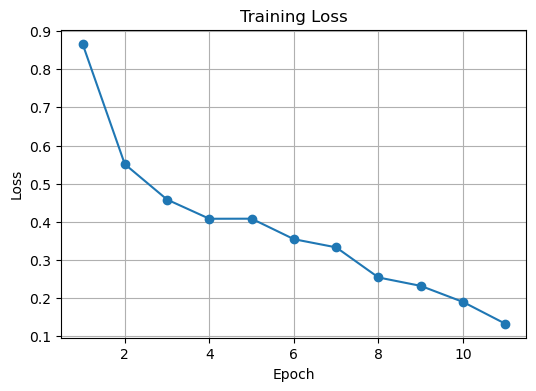


Final Classification Report:
                precision    recall  f1-score   support

         No_DR     0.9702    0.9702    0.9702       369
          Mild     0.5567    0.7105    0.6243        76
      Moderate     0.7713    0.7073    0.7379       205
        Severe     0.3421    0.3714    0.3562        35
Proliferate_DR     0.7073    0.6042    0.6517        48

      accuracy                         0.8172       733
     macro avg     0.6695    0.6727    0.6680       733
  weighted avg     0.8245    0.8172    0.8192       733



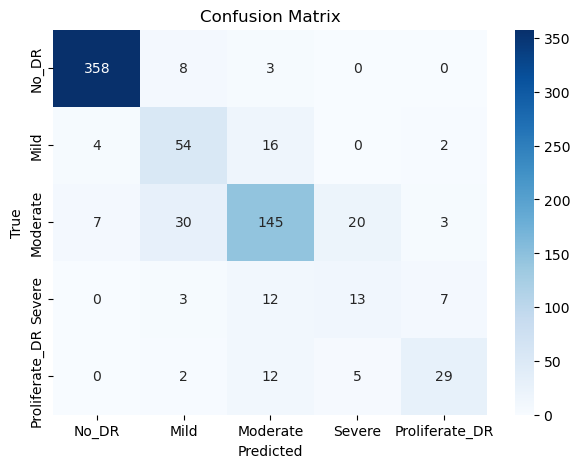

C:\Users\Sahil\AppData\Local\Temp\ipykernel_17812\2603496916.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_loc


🎯 Generating Grad-CAMs for one random validation image per class...
✅ Saved Grad-CAM for class 'No_DR' → Grad_Cam\No_DR_gradcam.jpg
✅ Saved Grad-CAM for class 'Mild' → Grad_Cam\Mild_gradcam.jpg


c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✅ Saved Grad-CAM for class 'Moderate' → Grad_Cam\Moderate_gradcam.jpg
✅ Saved Grad-CAM for class 'Severe' → Grad_Cam\Severe_gradcam.jpg
✅ Saved Grad-CAM for class 'Proliferate_DR' → Grad_Cam\Proliferate_DR_gradcam.jpg

🎉 Saved 5 Grad-CAM(s) in 'Grad_Cam'


In [9]:
# ===============================================================
#  EfficientNet + CBAM + Distillation + Scheduler + EarlyStopping + Grad-CAM (self-contained)
# ===============================================================
import os
import random
import warnings
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix
import timm

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------
# Config (change only here)
# -------------------------
config = {
    "csv_path": "train.csv",          # if missing, code will fallback to ImageFolder on img_root
    "img_root": "colored_images",     # folder root OR ImageFolder root (class subfolders)
    "backbone": "efficientnet_b3",
    "num_classes": 5,
    "batch_size": 8,
    "epochs": 25,
    "lr": 1e-4,
    "use_cbam": True,
    "use_distill": False,
    "teacher_backbone": "efficientnet_b5",
    "loss_fn": "CrossEntropyLoss",
    "early_stop_patience": 5,
    "gradcam_out_dir": "Grad_Cam",
    "image_size": 224
}

# -------------------------
# Device
# -------------------------
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    # check for NVIDIA substring (usually present)
    if "NVIDIA" in device_name.upper():
        print(f"✅ Using NVIDIA GPU: {device_name}")
    else:
        print(f"⚠️ Using GPU (not clearly NVIDIA): {device_name}")
else:
    print("⚠️ No GPU found. Using CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Dataset loader: CSV-based or ImageFolder fallback
# -------------------------
transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CSV-based dataset class (keeps your original CSV logic)
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, img_exts=(".png", ".jpg", ".jpeg")):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform
        self.data.columns = [c.strip().lower() for c in self.data.columns]
        self.image_col = self.data.columns[0]
        self.label_col = self.data.columns[1]
        self.folder_names = sorted([f for f in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, f))])
        # numeric map (matches your earlier map)
        self.numeric_to_folder = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}
        self.img_exts = img_exts

    def __len__(self):
        return len(self.data)

    def _find_image(self, folder, img_id):
        for ext in self.img_exts:
            p = os.path.join(self.img_root, folder, f"{img_id}{ext}")
            if os.path.exists(p):
                return p
        p = os.path.join(self.img_root, folder, img_id)
        if os.path.exists(p):
            return p
        raise FileNotFoundError(f"Image for id {img_id} not found in {folder}")

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx][self.image_col])
        label_val = self.data.iloc[idx][self.label_col]
        if isinstance(label_val, (int, float)) or str(label_val).isdigit():
            label_val = int(label_val)
            folder_name = self.numeric_to_folder[label_val]
            label_idx = label_val
        else:
            folder_name = str(label_val)
            label_idx = self.folder_names.index(folder_name)
        img_path = self._find_image(folder_name, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# Build dataset: try CSV, else ImageFolder
dataset = None
use_imagefolder = False
if os.path.exists(config["csv_path"]) and os.path.isdir(config["img_root"]):
    try:
        dataset = RetinopathyDataset(config["csv_path"], config["img_root"], transform=transform)
        print("✅ Loaded dataset from CSV + folders.")
    except Exception as e:
        print(f"⚠️ Failed to load CSV-based dataset: {e}")
        dataset = None

if dataset is None:
    # fallback to ImageFolder
    if os.path.isdir(config["img_root"]):
        dataset = datasets.ImageFolder(root=config["img_root"],
                                       transform=transform)
        use_imagefolder = True
        print("✅ Loaded dataset with ImageFolder (class-subfolders).")
    else:
        raise FileNotFoundError(f"Neither CSV ({config['csv_path']}) nor image root ({config['img_root']}) exist.")

# class names
if use_imagefolder:
    class_names = dataset.classes
else:
    # use the numeric_to_folder mapping order
    class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

# train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False)

print(f"Dataset: {len(dataset)} images → train: {len(train_ds)}, val: {len(val_ds)}")
print("Classes:", class_names)

# -------------------------
# CBAM (Channel + Spatial) - same as your implementation
# -------------------------
class ChannelGate(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False)
        )

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = torch.mean(x, dim=(2, 3))
        max_pool, _ = torch.max(x.view(b, c, -1), dim=2)
        out = self.mlp(avg_pool) + self.mlp(max_pool)
        return torch.sigmoid(out).view(b, c, 1, 1)

class SpatialGate(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, mx], dim=1)
        out = self.bn(self.conv(cat))
        return torch.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_gate = ChannelGate(channels, reduction)
        self.spatial_gate = SpatialGate(kernel_size)

    def forward(self, x):
        x = x * self.channel_gate(x)
        x = x * self.spatial_gate(x)
        return x

# -------------------------
# Model (EfficientNet features_only as before)
# -------------------------
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', num_classes=5, use_cbam=True, pretrained=True):
        super().__init__()
        # create a features-only model and keep the last feature map
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.feature_extractor = timm.create_model(backbone_name, pretrained=pretrained, features_only=True)
        out_channels = self.feature_extractor.feature_info[-1]['num_chs']
        self.use_cbam = use_cbam
        self.cbam = CBAMBlock(out_channels) if use_cbam else None
        self.classifier = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if isinstance(feats, (list, tuple)):
            feats = feats[-1]  # last feature map (B, C, H, W)
        if self.cbam:
            feats = self.cbam(feats)
        pooled = nn.functional.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)
        logits = self.classifier(pooled)
        return logits

# -------------------------
# DistillationLoss (unchanged)
# -------------------------
class DistillationLoss(nn.Module):
    def __init__(self, base_loss, teacher_model, alpha=0.5, temperature=4.0):
        super().__init__()
        self.base_loss = base_loss
        self.teacher = teacher_model
        self.alpha = alpha
        self.T = temperature
        if self.teacher is not None:
            self.teacher.eval()
            for p in self.teacher.parameters():
                p.requires_grad = False

    def forward(self, student_logits, inputs, labels):
        hard = self.base_loss(student_logits, labels)
        if self.teacher is None:
            return hard
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)
        s_logp = nn.functional.log_softmax(student_logits / self.T, dim=1)
        t_prob = nn.functional.softmax(teacher_logits / self.T, dim=1)
        soft = nn.KLDivLoss(reduction='batchmean')(s_logp, t_prob) * (self.T * self.T)
        return self.alpha * soft + (1.0 - self.alpha) * hard

# -------------------------
# Trainer (unchanged)
# -------------------------
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train_epoch(self, loader, epoch_idx=0):
        self.model.train()
        running_loss = 0.0
        n = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.criterion(outputs, imgs, labels) if isinstance(self.criterion, DistillationLoss) else self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            if self.scheduler is not None:
                # scheduler is OneCycleLR; step per batch
                try:
                    self.scheduler.step()
                except Exception:
                    pass
            running_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
        return running_loss / max(1, n)

    def evaluate(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                preds.extend(outputs.argmax(1).cpu().numpy().tolist())
                trues.extend(labels.numpy().tolist())
        return preds, trues

# -------------------------
# Initialize model, loss, optimizer, scheduler
# -------------------------
teacher_model = None
if config["use_distill"]:
    teacher_model = timm.create_model(config["teacher_backbone"], pretrained=True, num_classes=config["num_classes"]).to(device).eval()

# choose base loss from config
loss_name = config["loss_fn"].lower()
if loss_name == "crossentropyloss" or loss_name == "crossentropy":
    base_loss = nn.CrossEntropyLoss()
elif loss_name == "mse":
    base_loss = nn.MSELoss()
elif loss_name == "l1loss" or loss_name == "l1":
    base_loss = nn.L1Loss()
elif loss_name == "huberloss":
    base_loss = nn.HuberLoss()
else:
    raise ValueError(f"Unsupported loss function: {config['loss_fn']}")

criterion = DistillationLoss(base_loss, teacher_model) if config["use_distill"] else base_loss

model = EfficientNetWithCBAM(config["backbone"], config["num_classes"], config["use_cbam"], pretrained=True).to(device)

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
# OneCycleLR requires steps_per_epoch; guard if loader empty
if len(train_loader) > 0:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["lr"] * 10,
        steps_per_epoch=len(train_loader),
        epochs=config["epochs"]
    )
else:
    scheduler = None

trainer = Trainer(model, criterion, optimizer, scheduler, device)

# -------------------------
# Training loop + validation + early stopping
# -------------------------
train_losses = []
best_val_loss = float("inf")
patience_counter = 0
patience = config["early_stop_patience"]

for epoch in range(config["epochs"]):
    train_loss = trainer.train_epoch(train_loader, epoch)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    total = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs, labels) if isinstance(criterion, DistillationLoss) else criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            total += imgs.size(0)
            preds.extend(outputs.argmax(1).cpu().numpy().tolist())
            trues.extend(labels.cpu().numpy().tolist())
    val_loss /= max(1, total)

    print(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # early stopping + save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Validation loss improved — model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

    # classification report each epoch
    try:
        print(classification_report(trues, preds, digits=4, target_names=class_names))
    except Exception:
        pass

# -------------------------
# Plot training loss
# -------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# -------------------------
# Final evaluation and confusion matrix
# -------------------------
preds, trues = trainer.evaluate(val_loader)
print("\nFinal Classification Report:")
print(classification_report(trues, preds, digits=4, target_names=class_names))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------
# Self-contained Grad-CAM implementation
# -------------------------
def find_last_conv_module(net):
    last_name = None
    last_mod = None
    for name, module in net.named_modules():
        if isinstance(module, nn.Conv2d):
            last_name = name
            last_mod = module
    return last_name, last_mod

def generate_gradcam(model, input_tensor, target_class, device):
    """
    Returns normalized heatmap (H x W) in range [0,1]
    input_tensor: (1,C,H,W) on device
    """
    model.eval()
    # find last conv
    last_name, last_conv = find_last_conv_module(model)
    if last_conv is None:
        raise RuntimeError("No Conv2d layer found in the model for Grad-CAM.")

    activations = {}
    gradients = {}

    def forward_hook(module, inp, out):
        activations['value'] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    fh = last_conv.register_forward_hook(forward_hook)
    bh = last_conv.register_backward_hook(backward_hook)

    # forward
    outputs = model(input_tensor)
    if isinstance(outputs, tuple):
        logits = outputs[0]
    else:
        logits = outputs
    score = logits[0, target_class]
    model.zero_grad()
    score.backward(retain_graph=True)

    # get grad and activation
    act = activations['value']          # shape (1, C, H, W)
    grad = gradients['value']           # shape (1, C, H, W)
    # global-average-pool the gradients to get weights
    weights = torch.mean(grad, dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
    cam_map = torch.sum(weights * act, dim=1, keepdim=True)  # (1,1,H,W)
    cam_map = torch.relu(cam_map)
    cam_map = cam_map.squeeze().cpu().numpy()  # (H, W)

    # normalize
    cam_map -= cam_map.min()
    if cam_map.max() != 0:
        cam_map /= cam_map.max()

    # remove hooks
    fh.remove()
    bh.remove()
    return cam_map  # numpy HxW in [0,1]

# -------------------------
# Save Grad-CAMs: pick one random val image per class
# -------------------------
os.makedirs(config["gradcam_out_dir"], exist_ok=True)
if not os.path.exists("best_model.pth"):
    print("⚠️ No best_model.pth found — using current model weights for Grad-CAM.")
else:
    model.load_state_dict(torch.load("best_model.pth", map_location=device))

model.to(device)
model.eval()

# build mapping of class->indices in validation set
indices_per_class = {i: [] for i in range(len(class_names))}
# val_ds is a Subset, iterate via its indices
if isinstance(val_ds, Subset):
    underlying_dataset = val_ds.dataset
    for local_idx, global_idx in enumerate(val_ds.indices):
        # access using val_ds[local_idx]
        try:
            img, lbl = val_ds[local_idx]
        except Exception:
            # fallback: index into underlying dataset
            img, lbl = underlying_dataset[global_idx]
        indices_per_class[lbl].append(local_idx)
else:
    for i in range(len(val_ds)):
        _, lbl = val_ds[i]
        indices_per_class[lbl].append(i)

# inverse normalization helper
inv_mean = np.array([0.485, 0.456, 0.406])
inv_std = np.array([0.229, 0.224, 0.225])

print("\n🎯 Generating Grad-CAMs for one random validation image per class...")
saved_count = 0
for cls_idx, cls_name in enumerate(class_names):
    idxs = indices_per_class.get(cls_idx, [])
    if not idxs:
        print(f"⚠️ No samples for class {cls_name} in validation set; skipping.")
        continue
    # choose random sample in validation subset
    sel_local_idx = random.choice(idxs)
    img_tensor, lbl = val_ds[sel_local_idx]  # returns normalized tensor
    input_tensor = img_tensor.unsqueeze(0).to(device)

    target_class = int(lbl)
    try:
        cam = generate_gradcam(model, input_tensor, target_class, device)  # HxW float [0,1]
    except Exception as e:
        print(f"⚠️ Grad-CAM failed for class {cls_name}: {e}")
        continue

    # resize cam to image size
    cam_resized = cv2.resize(cam, (config["image_size"], config["image_size"]))
    heatmap = np.uint8(255 * cam_resized)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # BGR

    # reconstruct original image (unnormalize)
    img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
    img_np = (img_np * inv_std) + inv_mean  # un-normalize
    img_np = np.clip(img_np * 255.0, 0, 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # overlay
    overlay = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
    out_path = os.path.join(config["gradcam_out_dir"], f"{cls_name}_gradcam.jpg")
    cv2.imwrite(out_path, overlay)
    print(f"✅ Saved Grad-CAM for class '{cls_name}' → {out_path}")
    saved_count += 1

if saved_count == 0:
    print("⚠️ No Grad-CAMs were saved.")
else:
    print(f"\n🎉 Saved {saved_count} Grad-CAM(s) in '{config['gradcam_out_dir']}'")

# end of script


✅ Using NVIDIA GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Loaded dataset from CSV + folders.
Dataset: 3662 images → train: 2929, val: 733
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Epoch 1/25 - Train Loss: 3.3881 - Val Loss: 2.4309
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.4986    0.9780    0.6605       363
          Mild     1.0000    0.0127    0.0250        79
      Moderate     0.4444    0.0211    0.0402       190
        Severe     0.0909    0.0270    0.0417        37
Proliferate_DR     0.0000    0.0000    0.0000        64

      accuracy                         0.4925       733
     macro avg     0.4068    0.2077    0.1535       733
  weighted avg     0.4745    0.4925    0.3423       733

Epoch 2/25 - Train Loss: 2.3371 - Val Loss: 2.3259
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.5409    0.9477    0.6887       363
          Mild     0.6897    0.2532    0.3704        79
      Moderate     0.6154    0.0421    0.0788       190
        Severe     0.1455    0.2162    0.1739        37
Proliferate_DR     0.0000 

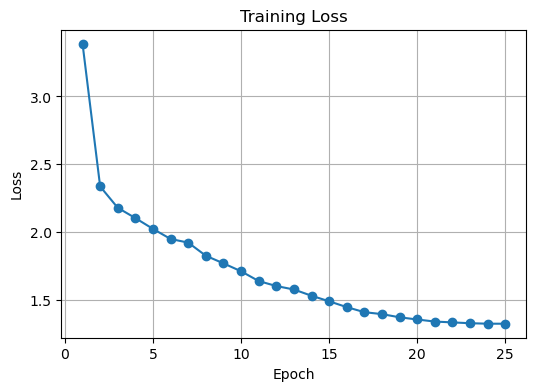


Final Classification Report:
                precision    recall  f1-score   support

         No_DR     0.4993    0.9725    0.6598       363
          Mild     0.0000    0.0000    0.0000        79
      Moderate     0.4286    0.0158    0.0305       190
        Severe     0.1053    0.0541    0.0714        37
Proliferate_DR     0.0000    0.0000    0.0000        64

      accuracy                         0.4884       733
     macro avg     0.2066    0.2085    0.1523       733
  weighted avg     0.3637    0.4884    0.3383       733



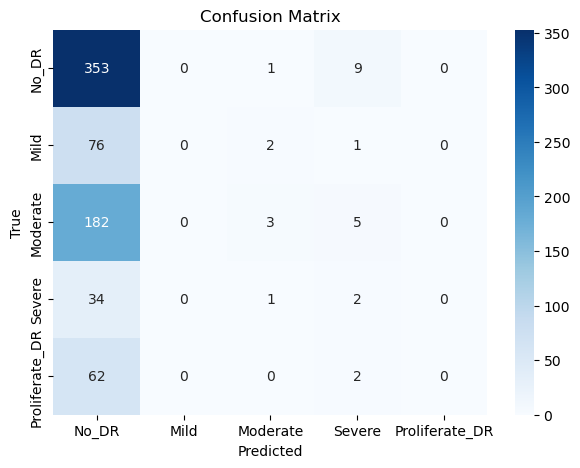

C:\Users\Sahil\AppData\Local\Temp\ipykernel_17812\1706646864.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_loc


🎯 Generating Grad-CAMs for one random validation image per class...
✅ Saved Grad-CAM for class 'No_DR' → Grad_Cam_Distill\No_DR_gradcam.jpg
✅ Saved Grad-CAM for class 'Mild' → Grad_Cam_Distill\Mild_gradcam.jpg


c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✅ Saved Grad-CAM for class 'Moderate' → Grad_Cam_Distill\Moderate_gradcam.jpg
✅ Saved Grad-CAM for class 'Severe' → Grad_Cam_Distill\Severe_gradcam.jpg
✅ Saved Grad-CAM for class 'Proliferate_DR' → Grad_Cam_Distill\Proliferate_DR_gradcam.jpg

🎉 Saved 5 Grad-CAM(s) in 'Grad_Cam_Distill'


In [10]:
# ===============================================================
#  EfficientNet + CBAM + Distillation + Scheduler + EarlyStopping + Grad-CAM (self-contained)
# ===============================================================
import os
import random
import warnings
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix
import timm

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------
# Config (change only here)
# -------------------------
config = {
    "csv_path": "train.csv",          # if missing, code will fallback to ImageFolder on img_root
    "img_root": "colored_images",     # folder root OR ImageFolder root (class subfolders)
    "backbone": "efficientnet_b3",
    "num_classes": 5,
    "batch_size": 8,
    "epochs": 25,
    "lr": 1e-4,
    "use_cbam": True,
    "use_distill": True,
    "teacher_backbone": "efficientnet_b5",
    "loss_fn": "CrossEntropyLoss",
    "early_stop_patience": 5,
    "gradcam_out_dir": "Grad_Cam_Distill",
    "image_size": 224
}

# -------------------------
# Device
# -------------------------
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    # check for NVIDIA substring (usually present)
    if "NVIDIA" in device_name.upper():
        print(f"✅ Using NVIDIA GPU: {device_name}")
    else:
        print(f"⚠️ Using GPU (not clearly NVIDIA): {device_name}")
else:
    print("⚠️ No GPU found. Using CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Dataset loader: CSV-based or ImageFolder fallback
# -------------------------
transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CSV-based dataset class (keeps your original CSV logic)
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, img_exts=(".png", ".jpg", ".jpeg")):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform
        self.data.columns = [c.strip().lower() for c in self.data.columns]
        self.image_col = self.data.columns[0]
        self.label_col = self.data.columns[1]
        self.folder_names = sorted([f for f in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, f))])
        # numeric map (matches your earlier map)
        self.numeric_to_folder = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}
        self.img_exts = img_exts

    def __len__(self):
        return len(self.data)

    def _find_image(self, folder, img_id):
        for ext in self.img_exts:
            p = os.path.join(self.img_root, folder, f"{img_id}{ext}")
            if os.path.exists(p):
                return p
        p = os.path.join(self.img_root, folder, img_id)
        if os.path.exists(p):
            return p
        raise FileNotFoundError(f"Image for id {img_id} not found in {folder}")

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx][self.image_col])
        label_val = self.data.iloc[idx][self.label_col]
        if isinstance(label_val, (int, float)) or str(label_val).isdigit():
            label_val = int(label_val)
            folder_name = self.numeric_to_folder[label_val]
            label_idx = label_val
        else:
            folder_name = str(label_val)
            label_idx = self.folder_names.index(folder_name)
        img_path = self._find_image(folder_name, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# Build dataset: try CSV, else ImageFolder
dataset = None
use_imagefolder = False
if os.path.exists(config["csv_path"]) and os.path.isdir(config["img_root"]):
    try:
        dataset = RetinopathyDataset(config["csv_path"], config["img_root"], transform=transform)
        print("✅ Loaded dataset from CSV + folders.")
    except Exception as e:
        print(f"⚠️ Failed to load CSV-based dataset: {e}")
        dataset = None

if dataset is None:
    # fallback to ImageFolder
    if os.path.isdir(config["img_root"]):
        dataset = datasets.ImageFolder(root=config["img_root"],
                                       transform=transform)
        use_imagefolder = True
        print("✅ Loaded dataset with ImageFolder (class-subfolders).")
    else:
        raise FileNotFoundError(f"Neither CSV ({config['csv_path']}) nor image root ({config['img_root']}) exist.")

# class names
if use_imagefolder:
    class_names = dataset.classes
else:
    # use the numeric_to_folder mapping order
    class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

# train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False)

print(f"Dataset: {len(dataset)} images → train: {len(train_ds)}, val: {len(val_ds)}")
print("Classes:", class_names)

# -------------------------
# CBAM (Channel + Spatial) - same as your implementation
# -------------------------
class ChannelGate(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False)
        )

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = torch.mean(x, dim=(2, 3))
        max_pool, _ = torch.max(x.view(b, c, -1), dim=2)
        out = self.mlp(avg_pool) + self.mlp(max_pool)
        return torch.sigmoid(out).view(b, c, 1, 1)

class SpatialGate(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, mx], dim=1)
        out = self.bn(self.conv(cat))
        return torch.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_gate = ChannelGate(channels, reduction)
        self.spatial_gate = SpatialGate(kernel_size)

    def forward(self, x):
        x = x * self.channel_gate(x)
        x = x * self.spatial_gate(x)
        return x

# -------------------------
# Model (EfficientNet features_only as before)
# -------------------------
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', num_classes=5, use_cbam=True, pretrained=True):
        super().__init__()
        # create a features-only model and keep the last feature map
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.feature_extractor = timm.create_model(backbone_name, pretrained=pretrained, features_only=True)
        out_channels = self.feature_extractor.feature_info[-1]['num_chs']
        self.use_cbam = use_cbam
        self.cbam = CBAMBlock(out_channels) if use_cbam else None
        self.classifier = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if isinstance(feats, (list, tuple)):
            feats = feats[-1]  # last feature map (B, C, H, W)
        if self.cbam:
            feats = self.cbam(feats)
        pooled = nn.functional.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)
        logits = self.classifier(pooled)
        return logits

# -------------------------
# DistillationLoss (unchanged)
# -------------------------
class DistillationLoss(nn.Module):
    def __init__(self, base_loss, teacher_model, alpha=0.5, temperature=4.0):
        super().__init__()
        self.base_loss = base_loss
        self.teacher = teacher_model
        self.alpha = alpha
        self.T = temperature
        if self.teacher is not None:
            self.teacher.eval()
            for p in self.teacher.parameters():
                p.requires_grad = False

    def forward(self, student_logits, inputs, labels):
        hard = self.base_loss(student_logits, labels)
        if self.teacher is None:
            return hard
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)
        s_logp = nn.functional.log_softmax(student_logits / self.T, dim=1)
        t_prob = nn.functional.softmax(teacher_logits / self.T, dim=1)
        soft = nn.KLDivLoss(reduction='batchmean')(s_logp, t_prob) * (self.T * self.T)
        return self.alpha * soft + (1.0 - self.alpha) * hard

# -------------------------
# Trainer (unchanged)
# -------------------------
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train_epoch(self, loader, epoch_idx=0):
        self.model.train()
        running_loss = 0.0
        n = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.criterion(outputs, imgs, labels) if isinstance(self.criterion, DistillationLoss) else self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            if self.scheduler is not None:
                # scheduler is OneCycleLR; step per batch
                try:
                    self.scheduler.step()
                except Exception:
                    pass
            running_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
        return running_loss / max(1, n)

    def evaluate(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                preds.extend(outputs.argmax(1).cpu().numpy().tolist())
                trues.extend(labels.numpy().tolist())
        return preds, trues

# -------------------------
# Initialize model, loss, optimizer, scheduler
# -------------------------
teacher_model = None
if config["use_distill"]:
    teacher_model = timm.create_model(config["teacher_backbone"], pretrained=True, num_classes=config["num_classes"]).to(device).eval()

# choose base loss from config
loss_name = config["loss_fn"].lower()
if loss_name == "crossentropyloss" or loss_name == "crossentropy":
    base_loss = nn.CrossEntropyLoss()
elif loss_name == "mse":
    base_loss = nn.MSELoss()
elif loss_name == "l1loss" or loss_name == "l1":
    base_loss = nn.L1Loss()
elif loss_name == "huberloss":
    base_loss = nn.HuberLoss()
else:
    raise ValueError(f"Unsupported loss function: {config['loss_fn']}")

criterion = DistillationLoss(base_loss, teacher_model) if config["use_distill"] else base_loss

model = EfficientNetWithCBAM(config["backbone"], config["num_classes"], config["use_cbam"], pretrained=True).to(device)

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
# OneCycleLR requires steps_per_epoch; guard if loader empty
if len(train_loader) > 0:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["lr"] * 10,
        steps_per_epoch=len(train_loader),
        epochs=config["epochs"]
    )
else:
    scheduler = None

trainer = Trainer(model, criterion, optimizer, scheduler, device)

# -------------------------
# Training loop + validation + early stopping
# -------------------------
train_losses = []
best_val_loss = float("inf")
patience_counter = 0
patience = config["early_stop_patience"]

for epoch in range(config["epochs"]):
    train_loss = trainer.train_epoch(train_loader, epoch)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    total = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs, labels) if isinstance(criterion, DistillationLoss) else criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            total += imgs.size(0)
            preds.extend(outputs.argmax(1).cpu().numpy().tolist())
            trues.extend(labels.cpu().numpy().tolist())
    val_loss /= max(1, total)

    print(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # early stopping + save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Validation loss improved — model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

    # classification report each epoch
    try:
        print(classification_report(trues, preds, digits=4, target_names=class_names))
    except Exception:
        pass

# -------------------------
# Plot training loss
# -------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# -------------------------
# Final evaluation and confusion matrix
# -------------------------
preds, trues = trainer.evaluate(val_loader)
print("\nFinal Classification Report:")
print(classification_report(trues, preds, digits=4, target_names=class_names))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------
# Self-contained Grad-CAM implementation
# -------------------------
def find_last_conv_module(net):
    last_name = None
    last_mod = None
    for name, module in net.named_modules():
        if isinstance(module, nn.Conv2d):
            last_name = name
            last_mod = module
    return last_name, last_mod

def generate_gradcam(model, input_tensor, target_class, device):
    """
    Returns normalized heatmap (H x W) in range [0,1]
    input_tensor: (1,C,H,W) on device
    """
    model.eval()
    # find last conv
    last_name, last_conv = find_last_conv_module(model)
    if last_conv is None:
        raise RuntimeError("No Conv2d layer found in the model for Grad-CAM.")

    activations = {}
    gradients = {}

    def forward_hook(module, inp, out):
        activations['value'] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    fh = last_conv.register_forward_hook(forward_hook)
    bh = last_conv.register_backward_hook(backward_hook)

    # forward
    outputs = model(input_tensor)
    if isinstance(outputs, tuple):
        logits = outputs[0]
    else:
        logits = outputs
    score = logits[0, target_class]
    model.zero_grad()
    score.backward(retain_graph=True)

    # get grad and activation
    act = activations['value']          # shape (1, C, H, W)
    grad = gradients['value']           # shape (1, C, H, W)
    # global-average-pool the gradients to get weights
    weights = torch.mean(grad, dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
    cam_map = torch.sum(weights * act, dim=1, keepdim=True)  # (1,1,H,W)
    cam_map = torch.relu(cam_map)
    cam_map = cam_map.squeeze().cpu().numpy()  # (H, W)

    # normalize
    cam_map -= cam_map.min()
    if cam_map.max() != 0:
        cam_map /= cam_map.max()

    # remove hooks
    fh.remove()
    bh.remove()
    return cam_map  # numpy HxW in [0,1]

# -------------------------
# Save Grad-CAMs: pick one random val image per class
# -------------------------
os.makedirs(config["gradcam_out_dir"], exist_ok=True)
if not os.path.exists("best_model.pth"):
    print("⚠️ No best_model.pth found — using current model weights for Grad-CAM.")
else:
    model.load_state_dict(torch.load("best_model.pth", map_location=device))

model.to(device)
model.eval()

# build mapping of class->indices in validation set
indices_per_class = {i: [] for i in range(len(class_names))}
# val_ds is a Subset, iterate via its indices
if isinstance(val_ds, Subset):
    underlying_dataset = val_ds.dataset
    for local_idx, global_idx in enumerate(val_ds.indices):
        # access using val_ds[local_idx]
        try:
            img, lbl = val_ds[local_idx]
        except Exception:
            # fallback: index into underlying dataset
            img, lbl = underlying_dataset[global_idx]
        indices_per_class[lbl].append(local_idx)
else:
    for i in range(len(val_ds)):
        _, lbl = val_ds[i]
        indices_per_class[lbl].append(i)

# inverse normalization helper
inv_mean = np.array([0.485, 0.456, 0.406])
inv_std = np.array([0.229, 0.224, 0.225])

print("\n🎯 Generating Grad-CAMs for one random validation image per class...")
saved_count = 0
for cls_idx, cls_name in enumerate(class_names):
    idxs = indices_per_class.get(cls_idx, [])
    if not idxs:
        print(f"⚠️ No samples for class {cls_name} in validation set; skipping.")
        continue
    # choose random sample in validation subset
    sel_local_idx = random.choice(idxs)
    img_tensor, lbl = val_ds[sel_local_idx]  # returns normalized tensor
    input_tensor = img_tensor.unsqueeze(0).to(device)

    target_class = int(lbl)
    try:
        cam = generate_gradcam(model, input_tensor, target_class, device)  # HxW float [0,1]
    except Exception as e:
        print(f"⚠️ Grad-CAM failed for class {cls_name}: {e}")
        continue

    # resize cam to image size
    cam_resized = cv2.resize(cam, (config["image_size"], config["image_size"]))
    heatmap = np.uint8(255 * cam_resized)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # BGR

    # reconstruct original image (unnormalize)
    img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
    img_np = (img_np * inv_std) + inv_mean  # un-normalize
    img_np = np.clip(img_np * 255.0, 0, 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # overlay
    overlay = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
    out_path = os.path.join(config["gradcam_out_dir"], f"{cls_name}_gradcam.jpg")
    cv2.imwrite(out_path, overlay)
    print(f"✅ Saved Grad-CAM for class '{cls_name}' → {out_path}")
    saved_count += 1

if saved_count == 0:
    print("⚠️ No Grad-CAMs were saved.")
else:
    print(f"\n🎉 Saved {saved_count} Grad-CAM(s) in '{config['gradcam_out_dir']}'")

# end of script


✅ Using NVIDIA GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Loaded dataset from CSV + folders.
Dataset: 3662 images → train: 2929, val: 733
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Epoch 1/25 - Train Loss: 0.8217 - Val Loss: 0.6283
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.9148    0.9881    0.9501       337
          Mild     0.4839    0.5696    0.5233        79
      Moderate     0.7094    0.7580    0.7329       219
        Severe     0.3636    0.1250    0.1860        32
Proliferate_DR     0.5161    0.2424    0.3299        66

      accuracy                         0.7694       733
     macro avg     0.5976    0.5366    0.5444       733
  weighted avg     0.7470    0.7694    0.7500       733

Epoch 2/25 - Train Loss: 0.5292 - Val Loss: 0.5722
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.9511    0.9822    0.9664       337
          Mild     0.6429    0.3418    0.4463        79
      Moderate     0.6835    0.9269    0.7868       219
        Severe     0.4167    0.1562    0.2273        32
Proliferate_DR     0.7059 

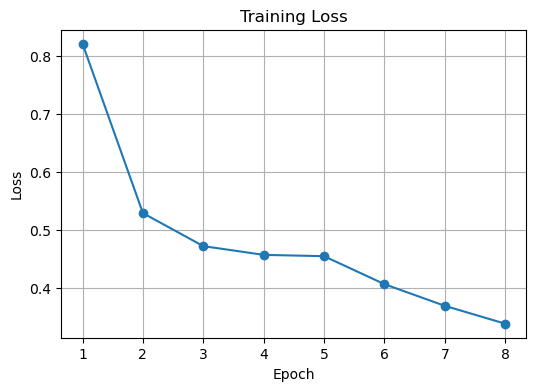


Final Classification Report:
                precision    recall  f1-score   support

         No_DR     0.9650    0.9822    0.9735       337
          Mild     0.5909    0.4937    0.5379        79
      Moderate     0.7542    0.8265    0.7887       219
        Severe     0.4286    0.0938    0.1538        32
Proliferate_DR     0.5584    0.6515    0.6014        66

      accuracy                         0.8145       733
     macro avg     0.6594    0.6095    0.6111       733
  weighted avg     0.8017    0.8145    0.8021       733



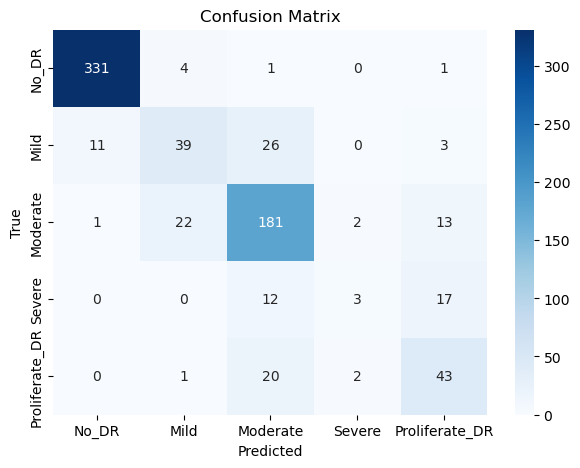

C:\Users\Sahil\AppData\Local\Temp\ipykernel_17812\219053540.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_loca


🎯 Generating Grad-CAMs for one random validation image per class...
✅ Saved Grad-CAM for class 'No_DR' → B2_B5\No_DR_gradcam.jpg


c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✅ Saved Grad-CAM for class 'Mild' → B2_B5\Mild_gradcam.jpg
✅ Saved Grad-CAM for class 'Moderate' → B2_B5\Moderate_gradcam.jpg
✅ Saved Grad-CAM for class 'Severe' → B2_B5\Severe_gradcam.jpg
✅ Saved Grad-CAM for class 'Proliferate_DR' → B2_B5\Proliferate_DR_gradcam.jpg

🎉 Saved 5 Grad-CAM(s) in 'B2_B5'


In [13]:

# ===============================================================
#  EfficientNet + CBAM + Distillation + Scheduler + EarlyStopping + Grad-CAM (self-contained)
# ===============================================================
import os
import random
import warnings
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix
import timm

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------
# Config (change only here)
# -------------------------
config = {
    "csv_path": "train.csv",          # if missing, code will fallback to ImageFolder on img_root
    "img_root": "colored_images",     # folder root OR ImageFolder root (class subfolders)
    "backbone": "efficientnet_b2",
    "num_classes": 5,
    "batch_size": 8,
    "epochs": 25,
    "lr": 1e-4,
    "use_cbam": True,
    "use_distill": False,
    "teacher_backbone": "efficientnet_b5",
    "loss_fn": "CrossEntropyLoss",
    "early_stop_patience": 5,
    "gradcam_out_dir": "B2_B5",
    "image_size": 224
}

# -------------------------
# Device
# -------------------------
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    # check for NVIDIA substring (usually present)
    if "NVIDIA" in device_name.upper():
        print(f"✅ Using NVIDIA GPU: {device_name}")
    else:
        print(f"⚠️ Using GPU (not clearly NVIDIA): {device_name}")
else:
    print("⚠️ No GPU found. Using CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Dataset loader: CSV-based or ImageFolder fallback
# -------------------------
transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CSV-based dataset class (keeps your original CSV logic)
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, img_exts=(".png", ".jpg", ".jpeg")):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform
        self.data.columns = [c.strip().lower() for c in self.data.columns]
        self.image_col = self.data.columns[0]
        self.label_col = self.data.columns[1]
        self.folder_names = sorted([f for f in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, f))])
        # numeric map (matches your earlier map)
        self.numeric_to_folder = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}
        self.img_exts = img_exts

    def __len__(self):
        return len(self.data)

    def _find_image(self, folder, img_id):
        for ext in self.img_exts:
            p = os.path.join(self.img_root, folder, f"{img_id}{ext}")
            if os.path.exists(p):
                return p
        p = os.path.join(self.img_root, folder, img_id)
        if os.path.exists(p):
            return p
        raise FileNotFoundError(f"Image for id {img_id} not found in {folder}")

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx][self.image_col])
        label_val = self.data.iloc[idx][self.label_col]
        if isinstance(label_val, (int, float)) or str(label_val).isdigit():
            label_val = int(label_val)
            folder_name = self.numeric_to_folder[label_val]
            label_idx = label_val
        else:
            folder_name = str(label_val)
            label_idx = self.folder_names.index(folder_name)
        img_path = self._find_image(folder_name, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# Build dataset: try CSV, else ImageFolder
dataset = None
use_imagefolder = False
if os.path.exists(config["csv_path"]) and os.path.isdir(config["img_root"]):
    try:
        dataset = RetinopathyDataset(config["csv_path"], config["img_root"], transform=transform)
        print("✅ Loaded dataset from CSV + folders.")
    except Exception as e:
        print(f"⚠️ Failed to load CSV-based dataset: {e}")
        dataset = None

if dataset is None:
    # fallback to ImageFolder
    if os.path.isdir(config["img_root"]):
        dataset = datasets.ImageFolder(root=config["img_root"],
                                       transform=transform)
        use_imagefolder = True
        print("✅ Loaded dataset with ImageFolder (class-subfolders).")
    else:
        raise FileNotFoundError(f"Neither CSV ({config['csv_path']}) nor image root ({config['img_root']}) exist.")

# class names
if use_imagefolder:
    class_names = dataset.classes
else:
    # use the numeric_to_folder mapping order
    class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

# train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False)

print(f"Dataset: {len(dataset)} images → train: {len(train_ds)}, val: {len(val_ds)}")
print("Classes:", class_names)

# -------------------------
# CBAM (Channel + Spatial) - same as your implementation
# -------------------------
class ChannelGate(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False)
        )

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = torch.mean(x, dim=(2, 3))
        max_pool, _ = torch.max(x.view(b, c, -1), dim=2)
        out = self.mlp(avg_pool) + self.mlp(max_pool)
        return torch.sigmoid(out).view(b, c, 1, 1)

class SpatialGate(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, mx], dim=1)
        out = self.bn(self.conv(cat))
        return torch.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_gate = ChannelGate(channels, reduction)
        self.spatial_gate = SpatialGate(kernel_size)

    def forward(self, x):
        x = x * self.channel_gate(x)
        x = x * self.spatial_gate(x)
        return x

# -------------------------
# Model (EfficientNet features_only as before)
# -------------------------
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', num_classes=5, use_cbam=True, pretrained=True):
        super().__init__()
        # create a features-only model and keep the last feature map
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.feature_extractor = timm.create_model(backbone_name, pretrained=pretrained, features_only=True)
        out_channels = self.feature_extractor.feature_info[-1]['num_chs']
        self.use_cbam = use_cbam
        self.cbam = CBAMBlock(out_channels) if use_cbam else None
        self.classifier = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if isinstance(feats, (list, tuple)):
            feats = feats[-1]  # last feature map (B, C, H, W)
        if self.cbam:
            feats = self.cbam(feats)
        pooled = nn.functional.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)
        logits = self.classifier(pooled)
        return logits

# -------------------------
# DistillationLoss (unchanged)
# -------------------------
class DistillationLoss(nn.Module):
    def __init__(self, base_loss, teacher_model, alpha=0.5, temperature=4.0):
        super().__init__()
        self.base_loss = base_loss
        self.teacher = teacher_model
        self.alpha = alpha
        self.T = temperature
        if self.teacher is not None:
            self.teacher.eval()
            for p in self.teacher.parameters():
                p.requires_grad = False

    def forward(self, student_logits, inputs, labels):
        hard = self.base_loss(student_logits, labels)
        if self.teacher is None:
            return hard
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)
        s_logp = nn.functional.log_softmax(student_logits / self.T, dim=1)
        t_prob = nn.functional.softmax(teacher_logits / self.T, dim=1)
        soft = nn.KLDivLoss(reduction='batchmean')(s_logp, t_prob) * (self.T * self.T)
        return self.alpha * soft + (1.0 - self.alpha) * hard

# -------------------------
# Trainer (unchanged)
# -------------------------
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train_epoch(self, loader, epoch_idx=0):
        self.model.train()
        running_loss = 0.0
        n = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.criterion(outputs, imgs, labels) if isinstance(self.criterion, DistillationLoss) else self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            if self.scheduler is not None:
                # scheduler is OneCycleLR; step per batch
                try:
                    self.scheduler.step()
                except Exception:
                    pass
            running_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
        return running_loss / max(1, n)

    def evaluate(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                preds.extend(outputs.argmax(1).cpu().numpy().tolist())
                trues.extend(labels.numpy().tolist())
        return preds, trues

# -------------------------
# Initialize model, loss, optimizer, scheduler
# -------------------------
teacher_model = None
if config["use_distill"]:
    teacher_model = timm.create_model(config["teacher_backbone"], pretrained=True, num_classes=config["num_classes"]).to(device).eval()

# choose base loss from config
loss_name = config["loss_fn"].lower()
if loss_name == "crossentropyloss" or loss_name == "crossentropy":
    base_loss = nn.CrossEntropyLoss()
elif loss_name == "mse":
    base_loss = nn.MSELoss()
elif loss_name == "l1loss" or loss_name == "l1":
    base_loss = nn.L1Loss()
elif loss_name == "huberloss":
    base_loss = nn.HuberLoss()
else:
    raise ValueError(f"Unsupported loss function: {config['loss_fn']}")

criterion = DistillationLoss(base_loss, teacher_model) if config["use_distill"] else base_loss

model = EfficientNetWithCBAM(config["backbone"], config["num_classes"], config["use_cbam"], pretrained=True).to(device)

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
# OneCycleLR requires steps_per_epoch; guard if loader empty
if len(train_loader) > 0:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["lr"] * 10,
        steps_per_epoch=len(train_loader),
        epochs=config["epochs"]
    )
else:
    scheduler = None

trainer = Trainer(model, criterion, optimizer, scheduler, device)

# -------------------------
# Training loop + validation + early stopping
# -------------------------
train_losses = []
best_val_loss = float("inf")
patience_counter = 0
patience = config["early_stop_patience"]

for epoch in range(config["epochs"]):
    train_loss = trainer.train_epoch(train_loader, epoch)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    total = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs, labels) if isinstance(criterion, DistillationLoss) else criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            total += imgs.size(0)
            preds.extend(outputs.argmax(1).cpu().numpy().tolist())
            trues.extend(labels.cpu().numpy().tolist())
    val_loss /= max(1, total)

    print(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # early stopping + save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Validation loss improved — model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

    # classification report each epoch
    try:
        print(classification_report(trues, preds, digits=4, target_names=class_names))
    except Exception:
        pass

# -------------------------
# Plot training loss
# -------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# -------------------------
# Final evaluation and confusion matrix
# -------------------------
preds, trues = trainer.evaluate(val_loader)
print("\nFinal Classification Report:")
print(classification_report(trues, preds, digits=4, target_names=class_names))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------
# Self-contained Grad-CAM implementation
# -------------------------
def find_last_conv_module(net):
    last_name = None
    last_mod = None
    for name, module in net.named_modules():
        if isinstance(module, nn.Conv2d):
            last_name = name
            last_mod = module
    return last_name, last_mod

def generate_gradcam(model, input_tensor, target_class, device):
    """
    Returns normalized heatmap (H x W) in range [0,1]
    input_tensor: (1,C,H,W) on device
    """
    model.eval()
    # find last conv
    last_name, last_conv = find_last_conv_module(model)
    if last_conv is None:
        raise RuntimeError("No Conv2d layer found in the model for Grad-CAM.")

    activations = {}
    gradients = {}

    def forward_hook(module, inp, out):
        activations['value'] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    fh = last_conv.register_forward_hook(forward_hook)
    bh = last_conv.register_backward_hook(backward_hook)

    # forward
    outputs = model(input_tensor)
    if isinstance(outputs, tuple):
        logits = outputs[0]
    else:
        logits = outputs
    score = logits[0, target_class]
    model.zero_grad()
    score.backward(retain_graph=True)

    # get grad and activation
    act = activations['value']          # shape (1, C, H, W)
    grad = gradients['value']           # shape (1, C, H, W)
    # global-average-pool the gradients to get weights
    weights = torch.mean(grad, dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
    cam_map = torch.sum(weights * act, dim=1, keepdim=True)  # (1,1,H,W)
    cam_map = torch.relu(cam_map)
    cam_map = cam_map.squeeze().cpu().numpy()  # (H, W)

    # normalize
    cam_map -= cam_map.min()
    if cam_map.max() != 0:
        cam_map /= cam_map.max()

    # remove hooks
    fh.remove()
    bh.remove()
    return cam_map  # numpy HxW in [0,1]

# -------------------------
# Save Grad-CAMs: pick one random val image per class
# -------------------------
os.makedirs(config["gradcam_out_dir"], exist_ok=True)
if not os.path.exists("best_model.pth"):
    print("⚠️ No best_model.pth found — using current model weights for Grad-CAM.")
else:
    model.load_state_dict(torch.load("best_model.pth", map_location=device))

model.to(device)
model.eval()

# build mapping of class->indices in validation set
indices_per_class = {i: [] for i in range(len(class_names))}
# val_ds is a Subset, iterate via its indices
if isinstance(val_ds, Subset):
    underlying_dataset = val_ds.dataset
    for local_idx, global_idx in enumerate(val_ds.indices):
        # access using val_ds[local_idx]
        try:
            img, lbl = val_ds[local_idx]
        except Exception:
            # fallback: index into underlying dataset
            img, lbl = underlying_dataset[global_idx]
        indices_per_class[lbl].append(local_idx)
else:
    for i in range(len(val_ds)):
        _, lbl = val_ds[i]
        indices_per_class[lbl].append(i)

# inverse normalization helper
inv_mean = np.array([0.485, 0.456, 0.406])
inv_std = np.array([0.229, 0.224, 0.225])

print("\n🎯 Generating Grad-CAMs for one random validation image per class...")
saved_count = 0
for cls_idx, cls_name in enumerate(class_names):
    idxs = indices_per_class.get(cls_idx, [])
    if not idxs:
        print(f"⚠️ No samples for class {cls_name} in validation set; skipping.")
        continue
    # choose random sample in validation subset
    sel_local_idx = random.choice(idxs)
    img_tensor, lbl = val_ds[sel_local_idx]  # returns normalized tensor
    input_tensor = img_tensor.unsqueeze(0).to(device)

    target_class = int(lbl)
    try:
        cam = generate_gradcam(model, input_tensor, target_class, device)  # HxW float [0,1]
    except Exception as e:
        print(f"⚠️ Grad-CAM failed for class {cls_name}: {e}")
        continue

    # resize cam to image size
    cam_resized = cv2.resize(cam, (config["image_size"], config["image_size"]))
    heatmap = np.uint8(255 * cam_resized)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # BGR

    # reconstruct original image (unnormalize)
    img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
    img_np = (img_np * inv_std) + inv_mean  # un-normalize
    img_np = np.clip(img_np * 255.0, 0, 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # overlay
    overlay = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
    out_path = os.path.join(config["gradcam_out_dir"], f"{cls_name}_gradcam.jpg")
    cv2.imwrite(out_path, overlay)
    print(f"✅ Saved Grad-CAM for class '{cls_name}' → {out_path}")
    saved_count += 1

if saved_count == 0:
    print("⚠️ No Grad-CAMs were saved.")
else:
    print(f"\n🎉 Saved {saved_count} Grad-CAM(s) in '{config['gradcam_out_dir']}'")

# end of script


✅ Using NVIDIA GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Loaded dataset from CSV + folders.
Dataset: 3662 images → train: 2929, val: 733
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Epoch 1/25 - Train Loss: 2.7903 - Val Loss: 2.2434
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.9867    0.1942    0.3246       381
          Mild     0.1290    0.0964    0.1103        83
      Moderate     0.7368    0.2456    0.3684       171
        Severe     0.0668    0.8000    0.1233        45
Proliferate_DR     0.0000    0.0000    0.0000        53

      accuracy                         0.2183       733
     macro avg     0.3839    0.2672    0.1853       733
  weighted avg     0.7035    0.2183    0.2747       733

Epoch 2/25 - Train Loss: 2.2473 - Val Loss: 2.1748
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     1.0000    0.0289    0.0561       381
          Mild     0.1913    0.2651    0.2222        83
      Moderate     0.8919    0.1930    0.3173       171
        Severe     0.0582    0.7333    0.1078        45
Proliferate_DR     0.6667 

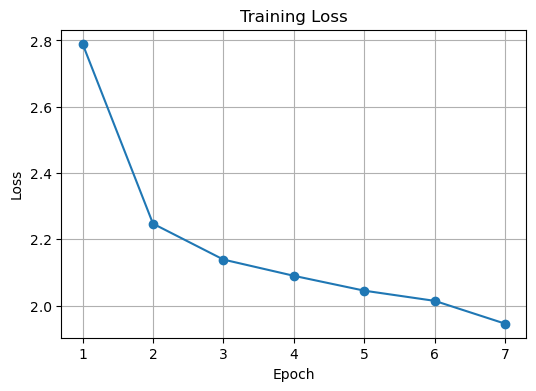


Final Classification Report:
                precision    recall  f1-score   support

         No_DR     0.9630    0.3412    0.5039       381
          Mild     0.1515    0.1807    0.1648        83
      Moderate     0.6479    0.2690    0.3802       171
        Severe     0.0678    0.6444    0.1226        45
Proliferate_DR     0.0000    0.0000    0.0000        53

      accuracy                         0.3001       733
     macro avg     0.3660    0.2871    0.2343       733
  weighted avg     0.6730    0.3001    0.3768       733



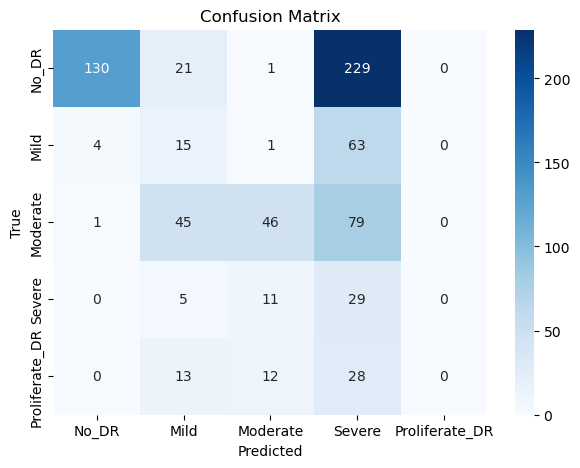

C:\Users\Sahil\AppData\Local\Temp\ipykernel_17812\3067629972.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_loc


🎯 Generating Grad-CAMs for one random validation image per class...
✅ Saved Grad-CAM for class 'No_DR' → B2_B5_Distill\No_DR_gradcam.jpg


c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✅ Saved Grad-CAM for class 'Mild' → B2_B5_Distill\Mild_gradcam.jpg
✅ Saved Grad-CAM for class 'Moderate' → B2_B5_Distill\Moderate_gradcam.jpg
✅ Saved Grad-CAM for class 'Severe' → B2_B5_Distill\Severe_gradcam.jpg
✅ Saved Grad-CAM for class 'Proliferate_DR' → B2_B5_Distill\Proliferate_DR_gradcam.jpg

🎉 Saved 5 Grad-CAM(s) in 'B2_B5_Distill'


In [15]:

# ===============================================================
#  EfficientNet + CBAM + Distillation + Scheduler + EarlyStopping + Grad-CAM (self-contained)
# ===============================================================
import os
import random
import warnings
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix
import timm

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------
# Config (change only here)
# -------------------------
config = {
    "csv_path": "train.csv",          # if missing, code will fallback to ImageFolder on img_root
    "img_root": "colored_images",     # folder root OR ImageFolder root (class subfolders)
    "backbone": "efficientnet_b2",
    "num_classes": 5,
    "batch_size": 8,
    "epochs": 25,
    "lr": 1e-4,
    "use_cbam": True,
    "use_distill": True,
    "teacher_backbone": "efficientnet_b5",
    "loss_fn": "CrossEntropyLoss",
    "early_stop_patience": 5,
    "gradcam_out_dir": "B2_B5_Distill",
    "image_size": 224
}

# -------------------------
# Device
# -------------------------
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    # check for NVIDIA substring (usually present)
    if "NVIDIA" in device_name.upper():
        print(f"✅ Using NVIDIA GPU: {device_name}")
    else:
        print(f"⚠️ Using GPU (not clearly NVIDIA): {device_name}")
else:
    print("⚠️ No GPU found. Using CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Dataset loader: CSV-based or ImageFolder fallback
# -------------------------
transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CSV-based dataset class (keeps your original CSV logic)
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, img_exts=(".png", ".jpg", ".jpeg")):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform
        self.data.columns = [c.strip().lower() for c in self.data.columns]
        self.image_col = self.data.columns[0]
        self.label_col = self.data.columns[1]
        self.folder_names = sorted([f for f in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, f))])
        # numeric map (matches your earlier map)
        self.numeric_to_folder = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}
        self.img_exts = img_exts

    def __len__(self):
        return len(self.data)

    def _find_image(self, folder, img_id):
        for ext in self.img_exts:
            p = os.path.join(self.img_root, folder, f"{img_id}{ext}")
            if os.path.exists(p):
                return p
        p = os.path.join(self.img_root, folder, img_id)
        if os.path.exists(p):
            return p
        raise FileNotFoundError(f"Image for id {img_id} not found in {folder}")

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx][self.image_col])
        label_val = self.data.iloc[idx][self.label_col]
        if isinstance(label_val, (int, float)) or str(label_val).isdigit():
            label_val = int(label_val)
            folder_name = self.numeric_to_folder[label_val]
            label_idx = label_val
        else:
            folder_name = str(label_val)
            label_idx = self.folder_names.index(folder_name)
        img_path = self._find_image(folder_name, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# Build dataset: try CSV, else ImageFolder
dataset = None
use_imagefolder = False
if os.path.exists(config["csv_path"]) and os.path.isdir(config["img_root"]):
    try:
        dataset = RetinopathyDataset(config["csv_path"], config["img_root"], transform=transform)
        print("✅ Loaded dataset from CSV + folders.")
    except Exception as e:
        print(f"⚠️ Failed to load CSV-based dataset: {e}")
        dataset = None

if dataset is None:
    # fallback to ImageFolder
    if os.path.isdir(config["img_root"]):
        dataset = datasets.ImageFolder(root=config["img_root"],
                                       transform=transform)
        use_imagefolder = True
        print("✅ Loaded dataset with ImageFolder (class-subfolders).")
    else:
        raise FileNotFoundError(f"Neither CSV ({config['csv_path']}) nor image root ({config['img_root']}) exist.")

# class names
if use_imagefolder:
    class_names = dataset.classes
else:
    # use the numeric_to_folder mapping order
    class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

# train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False)

print(f"Dataset: {len(dataset)} images → train: {len(train_ds)}, val: {len(val_ds)}")
print("Classes:", class_names)

# -------------------------
# CBAM (Channel + Spatial) - same as your implementation
# -------------------------
class ChannelGate(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False)
        )

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = torch.mean(x, dim=(2, 3))
        max_pool, _ = torch.max(x.view(b, c, -1), dim=2)
        out = self.mlp(avg_pool) + self.mlp(max_pool)
        return torch.sigmoid(out).view(b, c, 1, 1)

class SpatialGate(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, mx], dim=1)
        out = self.bn(self.conv(cat))
        return torch.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_gate = ChannelGate(channels, reduction)
        self.spatial_gate = SpatialGate(kernel_size)

    def forward(self, x):
        x = x * self.channel_gate(x)
        x = x * self.spatial_gate(x)
        return x

# -------------------------
# Model (EfficientNet features_only as before)
# -------------------------
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', num_classes=5, use_cbam=True, pretrained=True):
        super().__init__()
        # create a features-only model and keep the last feature map
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.feature_extractor = timm.create_model(backbone_name, pretrained=pretrained, features_only=True)
        out_channels = self.feature_extractor.feature_info[-1]['num_chs']
        self.use_cbam = use_cbam
        self.cbam = CBAMBlock(out_channels) if use_cbam else None
        self.classifier = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if isinstance(feats, (list, tuple)):
            feats = feats[-1]  # last feature map (B, C, H, W)
        if self.cbam:
            feats = self.cbam(feats)
        pooled = nn.functional.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)
        logits = self.classifier(pooled)
        return logits

# -------------------------
# DistillationLoss (unchanged)
# -------------------------
class DistillationLoss(nn.Module):
    def __init__(self, base_loss, teacher_model, alpha=0.5, temperature=4.0):
        super().__init__()
        self.base_loss = base_loss
        self.teacher = teacher_model
        self.alpha = alpha
        self.T = temperature
        if self.teacher is not None:
            self.teacher.eval()
            for p in self.teacher.parameters():
                p.requires_grad = False

    def forward(self, student_logits, inputs, labels):
        hard = self.base_loss(student_logits, labels)
        if self.teacher is None:
            return hard
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)
        s_logp = nn.functional.log_softmax(student_logits / self.T, dim=1)
        t_prob = nn.functional.softmax(teacher_logits / self.T, dim=1)
        soft = nn.KLDivLoss(reduction='batchmean')(s_logp, t_prob) * (self.T * self.T)
        return self.alpha * soft + (1.0 - self.alpha) * hard

# -------------------------
# Trainer (unchanged)
# -------------------------
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train_epoch(self, loader, epoch_idx=0):
        self.model.train()
        running_loss = 0.0
        n = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.criterion(outputs, imgs, labels) if isinstance(self.criterion, DistillationLoss) else self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            if self.scheduler is not None:
                # scheduler is OneCycleLR; step per batch
                try:
                    self.scheduler.step()
                except Exception:
                    pass
            running_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
        return running_loss / max(1, n)

    def evaluate(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                preds.extend(outputs.argmax(1).cpu().numpy().tolist())
                trues.extend(labels.numpy().tolist())
        return preds, trues

# -------------------------
# Initialize model, loss, optimizer, scheduler
# -------------------------
teacher_model = None
if config["use_distill"]:
    teacher_model = timm.create_model(config["teacher_backbone"], pretrained=True, num_classes=config["num_classes"]).to(device).eval()

# choose base loss from config
loss_name = config["loss_fn"].lower()
if loss_name == "crossentropyloss" or loss_name == "crossentropy":
    base_loss = nn.CrossEntropyLoss()
elif loss_name == "mse":
    base_loss = nn.MSELoss()
elif loss_name == "l1loss" or loss_name == "l1":
    base_loss = nn.L1Loss()
elif loss_name == "huberloss":
    base_loss = nn.HuberLoss()
else:
    raise ValueError(f"Unsupported loss function: {config['loss_fn']}")

criterion = DistillationLoss(base_loss, teacher_model) if config["use_distill"] else base_loss

model = EfficientNetWithCBAM(config["backbone"], config["num_classes"], config["use_cbam"], pretrained=True).to(device)

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
# OneCycleLR requires steps_per_epoch; guard if loader empty
if len(train_loader) > 0:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["lr"] * 10,
        steps_per_epoch=len(train_loader),
        epochs=config["epochs"]
    )
else:
    scheduler = None

trainer = Trainer(model, criterion, optimizer, scheduler, device)

# -------------------------
# Training loop + validation + early stopping
# -------------------------
train_losses = []
best_val_loss = float("inf")
patience_counter = 0
patience = config["early_stop_patience"]

for epoch in range(config["epochs"]):
    train_loss = trainer.train_epoch(train_loader, epoch)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    total = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs, labels) if isinstance(criterion, DistillationLoss) else criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            total += imgs.size(0)
            preds.extend(outputs.argmax(1).cpu().numpy().tolist())
            trues.extend(labels.cpu().numpy().tolist())
    val_loss /= max(1, total)

    print(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # early stopping + save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Validation loss improved — model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

    # classification report each epoch
    try:
        print(classification_report(trues, preds, digits=4, target_names=class_names))
    except Exception:
        pass

# -------------------------
# Plot training loss
# -------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# -------------------------
# Final evaluation and confusion matrix
# -------------------------
preds, trues = trainer.evaluate(val_loader)
print("\nFinal Classification Report:")
print(classification_report(trues, preds, digits=4, target_names=class_names))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------
# Self-contained Grad-CAM implementation
# -------------------------
def find_last_conv_module(net):
    last_name = None
    last_mod = None
    for name, module in net.named_modules():
        if isinstance(module, nn.Conv2d):
            last_name = name
            last_mod = module
    return last_name, last_mod

def generate_gradcam(model, input_tensor, target_class, device):
    """
    Returns normalized heatmap (H x W) in range [0,1]
    input_tensor: (1,C,H,W) on device
    """
    model.eval()
    # find last conv
    last_name, last_conv = find_last_conv_module(model)
    if last_conv is None:
        raise RuntimeError("No Conv2d layer found in the model for Grad-CAM.")

    activations = {}
    gradients = {}

    def forward_hook(module, inp, out):
        activations['value'] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    fh = last_conv.register_forward_hook(forward_hook)
    bh = last_conv.register_backward_hook(backward_hook)

    # forward
    outputs = model(input_tensor)
    if isinstance(outputs, tuple):
        logits = outputs[0]
    else:
        logits = outputs
    score = logits[0, target_class]
    model.zero_grad()
    score.backward(retain_graph=True)

    # get grad and activation
    act = activations['value']          # shape (1, C, H, W)
    grad = gradients['value']           # shape (1, C, H, W)
    # global-average-pool the gradients to get weights
    weights = torch.mean(grad, dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
    cam_map = torch.sum(weights * act, dim=1, keepdim=True)  # (1,1,H,W)
    cam_map = torch.relu(cam_map)
    cam_map = cam_map.squeeze().cpu().numpy()  # (H, W)

    # normalize
    cam_map -= cam_map.min()
    if cam_map.max() != 0:
        cam_map /= cam_map.max()

    # remove hooks
    fh.remove()
    bh.remove()
    return cam_map  # numpy HxW in [0,1]

# -------------------------
# Save Grad-CAMs: pick one random val image per class
# -------------------------
os.makedirs(config["gradcam_out_dir"], exist_ok=True)
if not os.path.exists("best_model.pth"):
    print("⚠️ No best_model.pth found — using current model weights for Grad-CAM.")
else:
    model.load_state_dict(torch.load("best_model.pth", map_location=device))

model.to(device)
model.eval()

# build mapping of class->indices in validation set
indices_per_class = {i: [] for i in range(len(class_names))}
# val_ds is a Subset, iterate via its indices
if isinstance(val_ds, Subset):
    underlying_dataset = val_ds.dataset
    for local_idx, global_idx in enumerate(val_ds.indices):
        # access using val_ds[local_idx]
        try:
            img, lbl = val_ds[local_idx]
        except Exception:
            # fallback: index into underlying dataset
            img, lbl = underlying_dataset[global_idx]
        indices_per_class[lbl].append(local_idx)
else:
    for i in range(len(val_ds)):
        _, lbl = val_ds[i]
        indices_per_class[lbl].append(i)

# inverse normalization helper
inv_mean = np.array([0.485, 0.456, 0.406])
inv_std = np.array([0.229, 0.224, 0.225])

print("\n🎯 Generating Grad-CAMs for one random validation image per class...")
saved_count = 0
for cls_idx, cls_name in enumerate(class_names):
    idxs = indices_per_class.get(cls_idx, [])
    if not idxs:
        print(f"⚠️ No samples for class {cls_name} in validation set; skipping.")
        continue
    # choose random sample in validation subset
    sel_local_idx = random.choice(idxs)
    img_tensor, lbl = val_ds[sel_local_idx]  # returns normalized tensor
    input_tensor = img_tensor.unsqueeze(0).to(device)

    target_class = int(lbl)
    try:
        cam = generate_gradcam(model, input_tensor, target_class, device)  # HxW float [0,1]
    except Exception as e:
        print(f"⚠️ Grad-CAM failed for class {cls_name}: {e}")
        continue

    # resize cam to image size
    cam_resized = cv2.resize(cam, (config["image_size"], config["image_size"]))
    heatmap = np.uint8(255 * cam_resized)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # BGR

    # reconstruct original image (unnormalize)
    img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
    img_np = (img_np * inv_std) + inv_mean  # un-normalize
    img_np = np.clip(img_np * 255.0, 0, 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # overlay
    overlay = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
    out_path = os.path.join(config["gradcam_out_dir"], f"{cls_name}_gradcam.jpg")
    cv2.imwrite(out_path, overlay)
    print(f"✅ Saved Grad-CAM for class '{cls_name}' → {out_path}")
    saved_count += 1

if saved_count == 0:
    print("⚠️ No Grad-CAMs were saved.")
else:
    print(f"\n🎉 Saved {saved_count} Grad-CAM(s) in '{config['gradcam_out_dir']}'")

# end of script


✅ Using NVIDIA GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Using data augmentation for training.
✅ Loaded dataset from CSV + folders.
✅ Using WeightedRandomSampler to handle class imbalance.
Dataset: 3662 images → train: 2929, val: 733
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Epoch 1/25 - Train Loss: 1.0509 - Val Loss: 0.6275
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.9309    0.9945    0.9617       366
          Mild     0.5347    0.6750    0.5967        80
      Moderate     0.7481    0.4975    0.5976       197
        Severe     0.2712    0.4706    0.3441        34
Proliferate_DR     0.4706    0.4286    0.4486        56

      accuracy                         0.7585       733
     macro avg     0.5911    0.6132    0.5897       733
  weighted avg     0.7728    0.7585    0.7561       733

Epoch 2/25 - Train Loss: 0.5233 - Val Loss: 0.7327
⚠️ No improvement for 1 epochs.
                precision    recall  f1-score   support

         No_DR     0.9626    0.9836    0.9730       366
          Mild     0.5133    0.7250    0.6010        80
      Moderate     0.7744    0.5228    0.6242       197
        Severe     0.3514    0.3824    0.3662        34
Proliferate_DR     0.4079    0.5536 

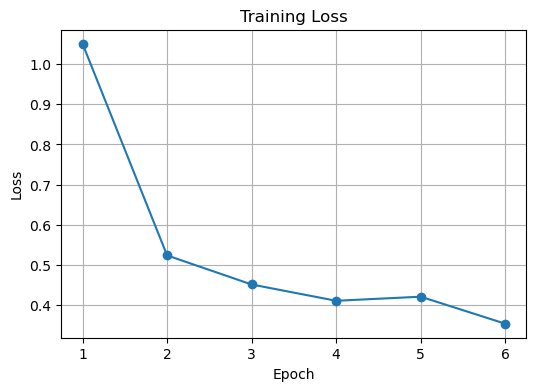


Final Classification Report:
                precision    recall  f1-score   support

         No_DR     0.9599    0.9809    0.9703       366
          Mild     0.4839    0.7500    0.5882        80
      Moderate     0.7719    0.4467    0.5659       197
        Severe     0.3231    0.6176    0.4242        34
Proliferate_DR     0.6071    0.6071    0.6071        56

      accuracy                         0.7667       733
     macro avg     0.6292    0.6805    0.6312       733
  weighted avg     0.8009    0.7667    0.7668       733



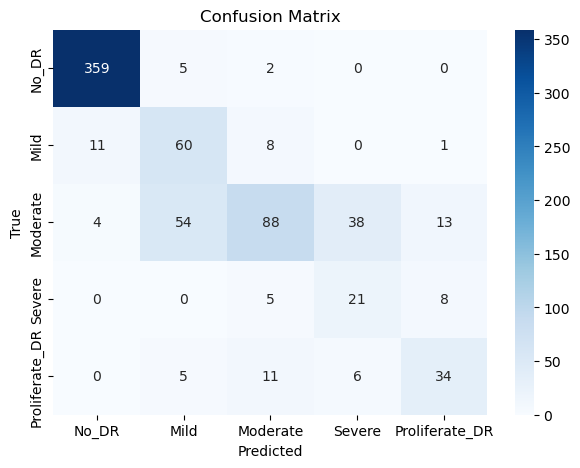

In [16]:
# ===============================================================
#  EfficientNet + CBAM + Distillation + Scheduler + EarlyStopping + Grad-CAM
#  With Configurable Data Augmentation + Weighted Sampler
# ===============================================================
import os
import random
import warnings
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix
import timm

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------
# Config (change only here)
# -------------------------
config = {
    "csv_path": "train.csv",          # if missing, code will fallback to ImageFolder
    "img_root": "colored_images",
    "backbone": "efficientnet_b2",
    "num_classes": 5,
    "batch_size": 8,
    "epochs": 25,
    "lr": 1e-4,
    "use_cbam": True,
    "use_distill": False,
    "teacher_backbone": "efficientnet_b5",
    "loss_fn": "CrossEntropyLoss",
    "early_stop_patience": 5,
    "gradcam_out_dir": "B2_B5_Augmentation",
    "image_size": 224,

    # NEW ↓↓↓
    "use_augmentation": True,          # toggle ON/OFF for data augmentation
    "use_weighted_sampler": True       # toggle ON/OFF for weighted sampling
}

# -------------------------
# Device
# -------------------------
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    if "NVIDIA" in device_name.upper():
        print(f"✅ Using NVIDIA GPU: {device_name}")
    else:
        print(f"⚠️ Using GPU (not clearly NVIDIA): {device_name}")
else:
    print("⚠️ No GPU found. Using CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Data Transformations
# -------------------------
if config["use_augmentation"]:
    print("✅ Using data augmentation for training.")
    train_transform = transforms.Compose([
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
else:
    print("ℹ️ Using basic preprocessing only (no augmentation).")
    train_transform = transforms.Compose([
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------------
# Dataset Loader (CSV-based or ImageFolder fallback)
# -------------------------
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, img_exts=(".png", ".jpg", ".jpeg")):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform
        self.data.columns = [c.strip().lower() for c in self.data.columns]
        self.image_col = self.data.columns[0]
        self.label_col = self.data.columns[1]
        self.folder_names = sorted([f for f in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, f))])
        self.numeric_to_folder = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}
        self.img_exts = img_exts

    def __len__(self):
        return len(self.data)

    def _find_image(self, folder, img_id):
        for ext in self.img_exts:
            p = os.path.join(self.img_root, folder, f"{img_id}{ext}")
            if os.path.exists(p):
                return p
        p = os.path.join(self.img_root, folder, img_id)
        if os.path.exists(p):
            return p
        raise FileNotFoundError(f"Image for id {img_id} not found in {folder}")

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx][self.image_col])
        label_val = self.data.iloc[idx][self.label_col]
        if isinstance(label_val, (int, float)) or str(label_val).isdigit():
            label_val = int(label_val)
            folder_name = self.numeric_to_folder[label_val]
            label_idx = label_val
        else:
            folder_name = str(label_val)
            label_idx = self.folder_names.index(folder_name)
        img_path = self._find_image(folder_name, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# Build dataset
dataset = None
use_imagefolder = False
if os.path.exists(config["csv_path"]) and os.path.isdir(config["img_root"]):
    try:
        full_dataset = RetinopathyDataset(config["csv_path"], config["img_root"], transform=None)
        print("✅ Loaded dataset from CSV + folders.")
    except Exception as e:
        print(f"⚠️ Failed to load CSV-based dataset: {e}")
        dataset = None
else:
    if os.path.isdir(config["img_root"]):
        full_dataset = datasets.ImageFolder(root=config["img_root"], transform=None)
        use_imagefolder = True
        print("✅ Loaded dataset with ImageFolder (class-subfolders).")
    else:
        raise FileNotFoundError(f"Neither CSV ({config['csv_path']}) nor image root ({config['img_root']}) exist.")

# class names
if use_imagefolder:
    class_names = full_dataset.classes
else:
    class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

# train/val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# apply transforms separately
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_transform

# -------------------------
# Weighted Sampler
# -------------------------
if config["use_weighted_sampler"]:
    print("✅ Using WeightedRandomSampler to handle class imbalance.")
    all_labels = []
    for idx in train_ds.indices:
        _, lbl = full_dataset[idx]
        all_labels.append(lbl)

    class_sample_count = np.array([len(np.where(np.array(all_labels) == t)[0]) for t in np.unique(all_labels)])
    class_weights = 1. / class_sample_count
    sample_weights = np.array([class_weights[t] for t in all_labels])
    sample_weights = torch.from_numpy(sample_weights).double()

    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], sampler=sampler)
else:
    print("ℹ️ Using random shuffle (no weighted sampler).")
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)

val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False)

print(f"Dataset: {len(full_dataset)} images → train: {len(train_ds)}, val: {len(val_ds)}")
print("Classes:", class_names)

# -------------------------
# CBAM Block
# -------------------------
class ChannelGate(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False)
        )

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = torch.mean(x, dim=(2, 3))
        max_pool, _ = torch.max(x.view(b, c, -1), dim=2)
        out = self.mlp(avg_pool) + self.mlp(max_pool)
        return torch.sigmoid(out).view(b, c, 1, 1)

class SpatialGate(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, mx], dim=1)
        out = self.bn(self.conv(cat))
        return torch.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_gate = ChannelGate(channels, reduction)
        self.spatial_gate = SpatialGate(kernel_size)

    def forward(self, x):
        x = x * self.channel_gate(x)
        x = x * self.spatial_gate(x)
        return x

# -------------------------
# Model Definition
# -------------------------
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', num_classes=5, use_cbam=True, pretrained=True):
        super().__init__()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.feature_extractor = timm.create_model(backbone_name, pretrained=pretrained, features_only=True)
        out_channels = self.feature_extractor.feature_info[-1]['num_chs']
        self.use_cbam = use_cbam
        self.cbam = CBAMBlock(out_channels) if use_cbam else None
        self.classifier = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if isinstance(feats, (list, tuple)):
            feats = feats[-1]
        if self.cbam:
            feats = self.cbam(feats)
        pooled = nn.functional.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)
        logits = self.classifier(pooled)
        return logits

# -------------------------
# Distillation Loss
# -------------------------
class DistillationLoss(nn.Module):
    def __init__(self, base_loss, teacher_model, alpha=0.5, temperature=4.0):
        super().__init__()
        self.base_loss = base_loss
        self.teacher = teacher_model
        self.alpha = alpha
        self.T = temperature
        if self.teacher is not None:
            self.teacher.eval()
            for p in self.teacher.parameters():
                p.requires_grad = False

    def forward(self, student_logits, inputs, labels):
        hard = self.base_loss(student_logits, labels)
        if self.teacher is None:
            return hard
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)
        s_logp = nn.functional.log_softmax(student_logits / self.T, dim=1)
        t_prob = nn.functional.softmax(teacher_logits / self.T, dim=1)
        soft = nn.KLDivLoss(reduction='batchmean')(s_logp, t_prob) * (self.T * self.T)
        return self.alpha * soft + (1.0 - self.alpha) * hard

# -------------------------
# Trainer
# -------------------------
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train_epoch(self, loader, epoch_idx=0):
        self.model.train()
        running_loss = 0.0
        n = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.criterion(outputs, imgs, labels) if isinstance(self.criterion, DistillationLoss) else self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            if self.scheduler is not None:
                try:
                    self.scheduler.step()
                except Exception:
                    pass
            running_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
        return running_loss / max(1, n)

    def evaluate(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                preds.extend(outputs.argmax(1).cpu().numpy().tolist())
                trues.extend(labels.numpy().tolist())
        return preds, trues

# -------------------------
# Initialize model, loss, optimizer, scheduler
# -------------------------
teacher_model = None
if config["use_distill"]:
    teacher_model = timm.create_model(config["teacher_backbone"], pretrained=True, num_classes=config["num_classes"]).to(device).eval()

loss_name = config["loss_fn"].lower()
if loss_name in ["crossentropyloss", "crossentropy"]:
    base_loss = nn.CrossEntropyLoss()
elif loss_name == "mse":
    base_loss = nn.MSELoss()
elif loss_name in ["l1loss", "l1"]:
    base_loss = nn.L1Loss()
elif loss_name == "huberloss":
    base_loss = nn.HuberLoss()
else:
    raise ValueError(f"Unsupported loss function: {config['loss_fn']}")

criterion = DistillationLoss(base_loss, teacher_model) if config["use_distill"] else base_loss
model = EfficientNetWithCBAM(config["backbone"], config["num_classes"], config["use_cbam"], pretrained=True).to(device)

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config["lr"] * 10,
    steps_per_epoch=len(train_loader),
    epochs=config["epochs"]
)

trainer = Trainer(model, criterion, optimizer, scheduler, device)

# -------------------------
# Training loop + early stopping
# -------------------------
train_losses = []
best_val_loss = float("inf")
patience_counter = 0
patience = config["early_stop_patience"]

for epoch in range(config["epochs"]):
    train_loss = trainer.train_epoch(train_loader, epoch)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    total = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs, labels) if isinstance(criterion, DistillationLoss) else criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            total += imgs.size(0)
            preds.extend(outputs.argmax(1).cpu().numpy().tolist())
            trues.extend(labels.cpu().numpy().tolist())
    val_loss /= max(1, total)

    print(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Validation loss improved — model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

    try:
        print(classification_report(trues, preds, digits=4, target_names=class_names))
    except Exception:
        pass

# -------------------------
# Plot training loss
# -------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# -------------------------
# Final Evaluation
# -------------------------
preds, trues = trainer.evaluate(val_loader)
print("\nFinal Classification Report:")
print(classification_report(trues, preds, digits=4, target_names=class_names))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


✅ Using NVIDIA GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Using data augmentation for training.
✅ Loaded dataset from CSV + folders.
✅ Using WeightedRandomSampler to handle class imbalance.
Dataset: 3662 images → train: 2929, val: 733
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Epoch 1/25 - Train Loss: 2.5357 - Val Loss: 2.2961
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.9714    0.1848    0.3105       368
          Mild     0.2788    0.4028    0.3295        72
      Moderate     0.7024    0.2965    0.4170       199
        Severe     0.6667    0.0513    0.0952        39
Proliferate_DR     0.0784    0.6727    0.1404        55

      accuracy                         0.2660       733
     macro avg     0.5395    0.3216    0.2585       733
  weighted avg     0.7471    0.2660    0.3171       733

Epoch 2/25 - Train Loss: 1.9531 - Val Loss: 2.2071
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     1.0000    0.0516    0.0982       368
          Mild     0.2340    0.1528    0.1849        72
      Moderate     0.7255    0.3719    0.4917       199
        Severe     0.5000    0.0513    0.0930        39
Proliferate_DR     0.0642 

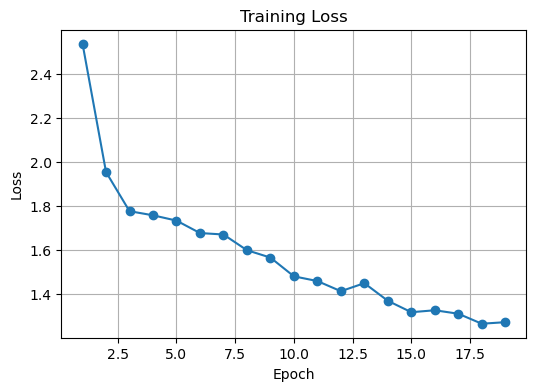


Final Classification Report:
                precision    recall  f1-score   support

         No_DR     1.0000    0.0897    0.1646       368
          Mild     0.3889    0.1944    0.2593        72
      Moderate     0.7869    0.4824    0.5981       199
        Severe     1.0000    0.0256    0.0500        39
Proliferate_DR     0.0850    0.8364    0.1544        55

      accuracy                         0.2592       733
     macro avg     0.6522    0.3257    0.2453       733
  weighted avg     0.8135    0.2592    0.2847       733



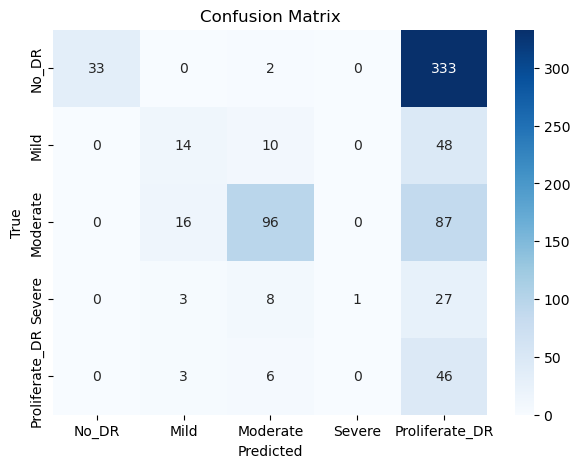

In [17]:
# ===============================================================
#  EfficientNet + CBAM + Distillation + Scheduler + EarlyStopping + Grad-CAM
#  With Configurable Data Augmentation + Weighted Sampler
# ===============================================================
import os
import random
import warnings
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix
import timm

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------
# Config (change only here)
# -------------------------
config = {
    "csv_path": "train.csv",          # if missing, code will fallback to ImageFolder
    "img_root": "colored_images",
    "backbone": "efficientnet_b2",
    "num_classes": 5,
    "batch_size": 8,
    "epochs": 25,
    "lr": 1e-4,
    "use_cbam": True,
    "use_distill": True,
    "teacher_backbone": "efficientnet_b5",
    "loss_fn": "CrossEntropyLoss",
    "early_stop_patience": 5,
    "gradcam_out_dir": "B2_B5_Distill_Augmentation",
    "image_size": 224,

    # NEW ↓↓↓
    "use_augmentation": True,          # toggle ON/OFF for data augmentation
    "use_weighted_sampler": True       # toggle ON/OFF for weighted sampling
}

# -------------------------
# Device
# -------------------------
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    if "NVIDIA" in device_name.upper():
        print(f"✅ Using NVIDIA GPU: {device_name}")
    else:
        print(f"⚠️ Using GPU (not clearly NVIDIA): {device_name}")
else:
    print("⚠️ No GPU found. Using CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Data Transformations
# -------------------------
if config["use_augmentation"]:
    print("✅ Using data augmentation for training.")
    train_transform = transforms.Compose([
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
else:
    print("ℹ️ Using basic preprocessing only (no augmentation).")
    train_transform = transforms.Compose([
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------------
# Dataset Loader (CSV-based or ImageFolder fallback)
# -------------------------
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, img_exts=(".png", ".jpg", ".jpeg")):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform
        self.data.columns = [c.strip().lower() for c in self.data.columns]
        self.image_col = self.data.columns[0]
        self.label_col = self.data.columns[1]
        self.folder_names = sorted([f for f in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, f))])
        self.numeric_to_folder = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}
        self.img_exts = img_exts

    def __len__(self):
        return len(self.data)

    def _find_image(self, folder, img_id):
        for ext in self.img_exts:
            p = os.path.join(self.img_root, folder, f"{img_id}{ext}")
            if os.path.exists(p):
                return p
        p = os.path.join(self.img_root, folder, img_id)
        if os.path.exists(p):
            return p
        raise FileNotFoundError(f"Image for id {img_id} not found in {folder}")

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx][self.image_col])
        label_val = self.data.iloc[idx][self.label_col]
        if isinstance(label_val, (int, float)) or str(label_val).isdigit():
            label_val = int(label_val)
            folder_name = self.numeric_to_folder[label_val]
            label_idx = label_val
        else:
            folder_name = str(label_val)
            label_idx = self.folder_names.index(folder_name)
        img_path = self._find_image(folder_name, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# Build dataset
dataset = None
use_imagefolder = False
if os.path.exists(config["csv_path"]) and os.path.isdir(config["img_root"]):
    try:
        full_dataset = RetinopathyDataset(config["csv_path"], config["img_root"], transform=None)
        print("✅ Loaded dataset from CSV + folders.")
    except Exception as e:
        print(f"⚠️ Failed to load CSV-based dataset: {e}")
        dataset = None
else:
    if os.path.isdir(config["img_root"]):
        full_dataset = datasets.ImageFolder(root=config["img_root"], transform=None)
        use_imagefolder = True
        print("✅ Loaded dataset with ImageFolder (class-subfolders).")
    else:
        raise FileNotFoundError(f"Neither CSV ({config['csv_path']}) nor image root ({config['img_root']}) exist.")

# class names
if use_imagefolder:
    class_names = full_dataset.classes
else:
    class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

# train/val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# apply transforms separately
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_transform

# -------------------------
# Weighted Sampler
# -------------------------
if config["use_weighted_sampler"]:
    print("✅ Using WeightedRandomSampler to handle class imbalance.")
    all_labels = []
    for idx in train_ds.indices:
        _, lbl = full_dataset[idx]
        all_labels.append(lbl)

    class_sample_count = np.array([len(np.where(np.array(all_labels) == t)[0]) for t in np.unique(all_labels)])
    class_weights = 1. / class_sample_count
    sample_weights = np.array([class_weights[t] for t in all_labels])
    sample_weights = torch.from_numpy(sample_weights).double()

    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], sampler=sampler)
else:
    print("ℹ️ Using random shuffle (no weighted sampler).")
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)

val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False)

print(f"Dataset: {len(full_dataset)} images → train: {len(train_ds)}, val: {len(val_ds)}")
print("Classes:", class_names)

# -------------------------
# CBAM Block
# -------------------------
class ChannelGate(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False)
        )

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = torch.mean(x, dim=(2, 3))
        max_pool, _ = torch.max(x.view(b, c, -1), dim=2)
        out = self.mlp(avg_pool) + self.mlp(max_pool)
        return torch.sigmoid(out).view(b, c, 1, 1)

class SpatialGate(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, mx], dim=1)
        out = self.bn(self.conv(cat))
        return torch.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_gate = ChannelGate(channels, reduction)
        self.spatial_gate = SpatialGate(kernel_size)

    def forward(self, x):
        x = x * self.channel_gate(x)
        x = x * self.spatial_gate(x)
        return x

# -------------------------
# Model Definition
# -------------------------
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', num_classes=5, use_cbam=True, pretrained=True):
        super().__init__()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.feature_extractor = timm.create_model(backbone_name, pretrained=pretrained, features_only=True)
        out_channels = self.feature_extractor.feature_info[-1]['num_chs']
        self.use_cbam = use_cbam
        self.cbam = CBAMBlock(out_channels) if use_cbam else None
        self.classifier = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if isinstance(feats, (list, tuple)):
            feats = feats[-1]
        if self.cbam:
            feats = self.cbam(feats)
        pooled = nn.functional.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)
        logits = self.classifier(pooled)
        return logits

# -------------------------
# Distillation Loss
# -------------------------
class DistillationLoss(nn.Module):
    def __init__(self, base_loss, teacher_model, alpha=0.5, temperature=4.0):
        super().__init__()
        self.base_loss = base_loss
        self.teacher = teacher_model
        self.alpha = alpha
        self.T = temperature
        if self.teacher is not None:
            self.teacher.eval()
            for p in self.teacher.parameters():
                p.requires_grad = False

    def forward(self, student_logits, inputs, labels):
        hard = self.base_loss(student_logits, labels)
        if self.teacher is None:
            return hard
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)
        s_logp = nn.functional.log_softmax(student_logits / self.T, dim=1)
        t_prob = nn.functional.softmax(teacher_logits / self.T, dim=1)
        soft = nn.KLDivLoss(reduction='batchmean')(s_logp, t_prob) * (self.T * self.T)
        return self.alpha * soft + (1.0 - self.alpha) * hard

# -------------------------
# Trainer
# -------------------------
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train_epoch(self, loader, epoch_idx=0):
        self.model.train()
        running_loss = 0.0
        n = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.criterion(outputs, imgs, labels) if isinstance(self.criterion, DistillationLoss) else self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            if self.scheduler is not None:
                try:
                    self.scheduler.step()
                except Exception:
                    pass
            running_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
        return running_loss / max(1, n)

    def evaluate(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                preds.extend(outputs.argmax(1).cpu().numpy().tolist())
                trues.extend(labels.numpy().tolist())
        return preds, trues

# -------------------------
# Initialize model, loss, optimizer, scheduler
# -------------------------
teacher_model = None
if config["use_distill"]:
    teacher_model = timm.create_model(config["teacher_backbone"], pretrained=True, num_classes=config["num_classes"]).to(device).eval()

loss_name = config["loss_fn"].lower()
if loss_name in ["crossentropyloss", "crossentropy"]:
    base_loss = nn.CrossEntropyLoss()
elif loss_name == "mse":
    base_loss = nn.MSELoss()
elif loss_name in ["l1loss", "l1"]:
    base_loss = nn.L1Loss()
elif loss_name == "huberloss":
    base_loss = nn.HuberLoss()
else:
    raise ValueError(f"Unsupported loss function: {config['loss_fn']}")

criterion = DistillationLoss(base_loss, teacher_model) if config["use_distill"] else base_loss
model = EfficientNetWithCBAM(config["backbone"], config["num_classes"], config["use_cbam"], pretrained=True).to(device)

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config["lr"] * 10,
    steps_per_epoch=len(train_loader),
    epochs=config["epochs"]
)

trainer = Trainer(model, criterion, optimizer, scheduler, device)

# -------------------------
# Training loop + early stopping
# -------------------------
train_losses = []
best_val_loss = float("inf")
patience_counter = 0
patience = config["early_stop_patience"]

for epoch in range(config["epochs"]):
    train_loss = trainer.train_epoch(train_loader, epoch)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    total = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs, labels) if isinstance(criterion, DistillationLoss) else criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            total += imgs.size(0)
            preds.extend(outputs.argmax(1).cpu().numpy().tolist())
            trues.extend(labels.cpu().numpy().tolist())
    val_loss /= max(1, total)

    print(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Validation loss improved — model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

    try:
        print(classification_report(trues, preds, digits=4, target_names=class_names))
    except Exception:
        pass

# -------------------------
# Plot training loss
# -------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# -------------------------
# Final Evaluation
# -------------------------
preds, trues = trainer.evaluate(val_loader)
print("\nFinal Classification Report:")
print(classification_report(trues, preds, digits=4, target_names=class_names))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


✅ Using NVIDIA GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Loaded dataset from CSV + folders.
Dataset: 3662 images → train: 2929, val: 733
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Epoch 1/25 - Train Loss: 2.0258 - Val Loss: 1.5430
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.9387    0.9768    0.9574       345
          Mild     0.0000    0.0000    0.0000        76
      Moderate     0.0000    0.0000    0.0000       207
        Severe     0.1096    1.0000    0.1976        41
Proliferate_DR     0.0000    0.0000    0.0000        64

      accuracy                         0.5157       733
     macro avg     0.2097    0.3954    0.2310       733
  weighted avg     0.4480    0.5157    0.4617       733

Epoch 2/25 - Train Loss: 1.5148 - Val Loss: 1.4673
✅ Validation loss improved — model saved.
                precision    recall  f1-score   support

         No_DR     0.9158    0.9768    0.9453       345
          Mild     0.6667    0.0263    0.0506        76
      Moderate     0.0000    0.0000    0.0000       207
        Severe     0.1105    0.9756    0.1985        41
Proliferate_DR     0.0000 

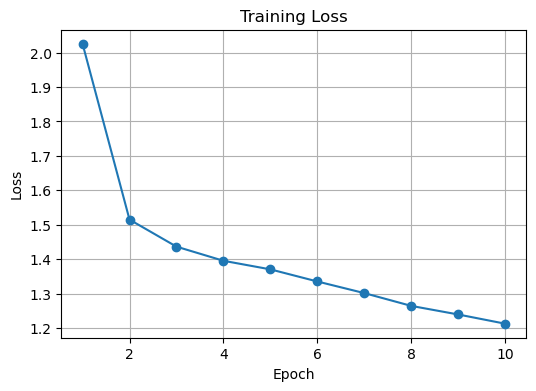


Final Classification Report:
                precision    recall  f1-score   support

         No_DR     0.8463    0.9739    0.9057       345
          Mild     0.6000    0.0395    0.0741        76
      Moderate     0.6000    0.0290    0.0553       207
        Severe     0.1104    0.8293    0.1948        41
Proliferate_DR     0.3846    0.0781    0.1299        64

      accuracy                         0.5239       733
     macro avg     0.5083    0.3900    0.2719       733
  weighted avg     0.6698    0.5239    0.4718       733



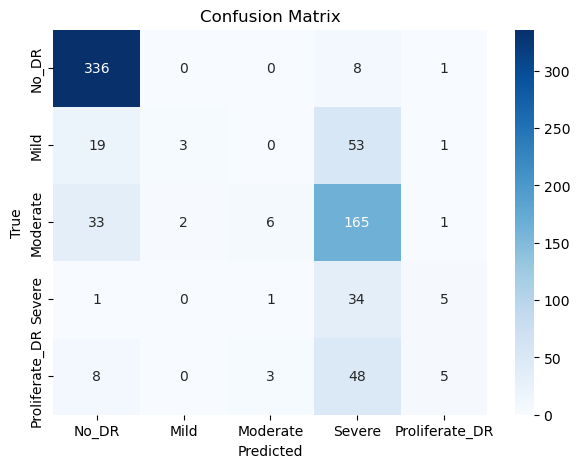

C:\Users\Sahil\AppData\Local\Temp\ipykernel_17812\851532522.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_loca


🎯 Generating Grad-CAMs for one random validation image per class...
✅ Saved Grad-CAM for class 'No_DR' → B0_B3\No_DR_gradcam.jpg


c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✅ Saved Grad-CAM for class 'Mild' → B0_B3\Mild_gradcam.jpg
✅ Saved Grad-CAM for class 'Moderate' → B0_B3\Moderate_gradcam.jpg
✅ Saved Grad-CAM for class 'Severe' → B0_B3\Severe_gradcam.jpg
✅ Saved Grad-CAM for class 'Proliferate_DR' → B0_B3\Proliferate_DR_gradcam.jpg

🎉 Saved 5 Grad-CAM(s) in 'B0_B3'


In [18]:

# ===============================================================
#  EfficientNet + CBAM + Distillation + Scheduler + EarlyStopping + Grad-CAM (self-contained)
# ===============================================================
import os
import random
import warnings
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix
import timm

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------
# Config (change only here)
# -------------------------
config = {
    "csv_path": "train.csv",          # if missing, code will fallback to ImageFolder on img_root
    "img_root": "colored_images",     # folder root OR ImageFolder root (class subfolders)
    "backbone": "efficientnet_b0",
    "num_classes": 5,
    "batch_size": 8,
    "epochs": 25,
    "lr": 1e-4,
    "use_cbam": True,
    "use_distill": True,
    "teacher_backbone": "efficientnet_b3",
    "loss_fn": "CrossEntropyLoss",
    "early_stop_patience": 5,
    "gradcam_out_dir": "B0_B3",
    "image_size": 224
}

# -------------------------
# Device
# -------------------------
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    # check for NVIDIA substring (usually present)
    if "NVIDIA" in device_name.upper():
        print(f"✅ Using NVIDIA GPU: {device_name}")
    else:
        print(f"⚠️ Using GPU (not clearly NVIDIA): {device_name}")
else:
    print("⚠️ No GPU found. Using CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Dataset loader: CSV-based or ImageFolder fallback
# -------------------------
transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CSV-based dataset class (keeps your original CSV logic)
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, img_exts=(".png", ".jpg", ".jpeg")):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform
        self.data.columns = [c.strip().lower() for c in self.data.columns]
        self.image_col = self.data.columns[0]
        self.label_col = self.data.columns[1]
        self.folder_names = sorted([f for f in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, f))])
        # numeric map (matches your earlier map)
        self.numeric_to_folder = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}
        self.img_exts = img_exts

    def __len__(self):
        return len(self.data)

    def _find_image(self, folder, img_id):
        for ext in self.img_exts:
            p = os.path.join(self.img_root, folder, f"{img_id}{ext}")
            if os.path.exists(p):
                return p
        p = os.path.join(self.img_root, folder, img_id)
        if os.path.exists(p):
            return p
        raise FileNotFoundError(f"Image for id {img_id} not found in {folder}")

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx][self.image_col])
        label_val = self.data.iloc[idx][self.label_col]
        if isinstance(label_val, (int, float)) or str(label_val).isdigit():
            label_val = int(label_val)
            folder_name = self.numeric_to_folder[label_val]
            label_idx = label_val
        else:
            folder_name = str(label_val)
            label_idx = self.folder_names.index(folder_name)
        img_path = self._find_image(folder_name, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# Build dataset: try CSV, else ImageFolder
dataset = None
use_imagefolder = False
if os.path.exists(config["csv_path"]) and os.path.isdir(config["img_root"]):
    try:
        dataset = RetinopathyDataset(config["csv_path"], config["img_root"], transform=transform)
        print("✅ Loaded dataset from CSV + folders.")
    except Exception as e:
        print(f"⚠️ Failed to load CSV-based dataset: {e}")
        dataset = None

if dataset is None:
    # fallback to ImageFolder
    if os.path.isdir(config["img_root"]):
        dataset = datasets.ImageFolder(root=config["img_root"],
                                       transform=transform)
        use_imagefolder = True
        print("✅ Loaded dataset with ImageFolder (class-subfolders).")
    else:
        raise FileNotFoundError(f"Neither CSV ({config['csv_path']}) nor image root ({config['img_root']}) exist.")

# class names
if use_imagefolder:
    class_names = dataset.classes
else:
    # use the numeric_to_folder mapping order
    class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

# train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False)

print(f"Dataset: {len(dataset)} images → train: {len(train_ds)}, val: {len(val_ds)}")
print("Classes:", class_names)

# -------------------------
# CBAM (Channel + Spatial) - same as your implementation
# -------------------------
class ChannelGate(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False)
        )

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = torch.mean(x, dim=(2, 3))
        max_pool, _ = torch.max(x.view(b, c, -1), dim=2)
        out = self.mlp(avg_pool) + self.mlp(max_pool)
        return torch.sigmoid(out).view(b, c, 1, 1)

class SpatialGate(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg, mx], dim=1)
        out = self.bn(self.conv(cat))
        return torch.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_gate = ChannelGate(channels, reduction)
        self.spatial_gate = SpatialGate(kernel_size)

    def forward(self, x):
        x = x * self.channel_gate(x)
        x = x * self.spatial_gate(x)
        return x

# -------------------------
# Model (EfficientNet features_only as before)
# -------------------------
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', num_classes=5, use_cbam=True, pretrained=True):
        super().__init__()
        # create a features-only model and keep the last feature map
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.feature_extractor = timm.create_model(backbone_name, pretrained=pretrained, features_only=True)
        out_channels = self.feature_extractor.feature_info[-1]['num_chs']
        self.use_cbam = use_cbam
        self.cbam = CBAMBlock(out_channels) if use_cbam else None
        self.classifier = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if isinstance(feats, (list, tuple)):
            feats = feats[-1]  # last feature map (B, C, H, W)
        if self.cbam:
            feats = self.cbam(feats)
        pooled = nn.functional.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)
        logits = self.classifier(pooled)
        return logits

# -------------------------
# DistillationLoss (unchanged)
# -------------------------
class DistillationLoss(nn.Module):
    def __init__(self, base_loss, teacher_model, alpha=0.5, temperature=4.0):
        super().__init__()
        self.base_loss = base_loss
        self.teacher = teacher_model
        self.alpha = alpha
        self.T = temperature
        if self.teacher is not None:
            self.teacher.eval()
            for p in self.teacher.parameters():
                p.requires_grad = False

    def forward(self, student_logits, inputs, labels):
        hard = self.base_loss(student_logits, labels)
        if self.teacher is None:
            return hard
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)
        s_logp = nn.functional.log_softmax(student_logits / self.T, dim=1)
        t_prob = nn.functional.softmax(teacher_logits / self.T, dim=1)
        soft = nn.KLDivLoss(reduction='batchmean')(s_logp, t_prob) * (self.T * self.T)
        return self.alpha * soft + (1.0 - self.alpha) * hard

# -------------------------
# Trainer (unchanged)
# -------------------------
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train_epoch(self, loader, epoch_idx=0):
        self.model.train()
        running_loss = 0.0
        n = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.criterion(outputs, imgs, labels) if isinstance(self.criterion, DistillationLoss) else self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            if self.scheduler is not None:
                # scheduler is OneCycleLR; step per batch
                try:
                    self.scheduler.step()
                except Exception:
                    pass
            running_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
        return running_loss / max(1, n)

    def evaluate(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                preds.extend(outputs.argmax(1).cpu().numpy().tolist())
                trues.extend(labels.numpy().tolist())
        return preds, trues

# -------------------------
# Initialize model, loss, optimizer, scheduler
# -------------------------
teacher_model = None
if config["use_distill"]:
    teacher_model = timm.create_model(config["teacher_backbone"], pretrained=True, num_classes=config["num_classes"]).to(device).eval()

# choose base loss from config
loss_name = config["loss_fn"].lower()
if loss_name == "crossentropyloss" or loss_name == "crossentropy":
    base_loss = nn.CrossEntropyLoss()
elif loss_name == "mse":
    base_loss = nn.MSELoss()
elif loss_name == "l1loss" or loss_name == "l1":
    base_loss = nn.L1Loss()
elif loss_name == "huberloss":
    base_loss = nn.HuberLoss()
else:
    raise ValueError(f"Unsupported loss function: {config['loss_fn']}")

criterion = DistillationLoss(base_loss, teacher_model) if config["use_distill"] else base_loss

model = EfficientNetWithCBAM(config["backbone"], config["num_classes"], config["use_cbam"], pretrained=True).to(device)

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
# OneCycleLR requires steps_per_epoch; guard if loader empty
if len(train_loader) > 0:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["lr"] * 10,
        steps_per_epoch=len(train_loader),
        epochs=config["epochs"]
    )
else:
    scheduler = None

trainer = Trainer(model, criterion, optimizer, scheduler, device)

# -------------------------
# Training loop + validation + early stopping
# -------------------------
train_losses = []
best_val_loss = float("inf")
patience_counter = 0
patience = config["early_stop_patience"]

for epoch in range(config["epochs"]):
    train_loss = trainer.train_epoch(train_loader, epoch)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    total = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs, labels) if isinstance(criterion, DistillationLoss) else criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            total += imgs.size(0)
            preds.extend(outputs.argmax(1).cpu().numpy().tolist())
            trues.extend(labels.cpu().numpy().tolist())
    val_loss /= max(1, total)

    print(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # early stopping + save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Validation loss improved — model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

    # classification report each epoch
    try:
        print(classification_report(trues, preds, digits=4, target_names=class_names))
    except Exception:
        pass

# -------------------------
# Plot training loss
# -------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# -------------------------
# Final evaluation and confusion matrix
# -------------------------
preds, trues = trainer.evaluate(val_loader)
print("\nFinal Classification Report:")
print(classification_report(trues, preds, digits=4, target_names=class_names))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------
# Self-contained Grad-CAM implementation
# -------------------------
def find_last_conv_module(net):
    last_name = None
    last_mod = None
    for name, module in net.named_modules():
        if isinstance(module, nn.Conv2d):
            last_name = name
            last_mod = module
    return last_name, last_mod

def generate_gradcam(model, input_tensor, target_class, device):
    """
    Returns normalized heatmap (H x W) in range [0,1]
    input_tensor: (1,C,H,W) on device
    """
    model.eval()
    # find last conv
    last_name, last_conv = find_last_conv_module(model)
    if last_conv is None:
        raise RuntimeError("No Conv2d layer found in the model for Grad-CAM.")

    activations = {}
    gradients = {}

    def forward_hook(module, inp, out):
        activations['value'] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    fh = last_conv.register_forward_hook(forward_hook)
    bh = last_conv.register_backward_hook(backward_hook)

    # forward
    outputs = model(input_tensor)
    if isinstance(outputs, tuple):
        logits = outputs[0]
    else:
        logits = outputs
    score = logits[0, target_class]
    model.zero_grad()
    score.backward(retain_graph=True)

    # get grad and activation
    act = activations['value']          # shape (1, C, H, W)
    grad = gradients['value']           # shape (1, C, H, W)
    # global-average-pool the gradients to get weights
    weights = torch.mean(grad, dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
    cam_map = torch.sum(weights * act, dim=1, keepdim=True)  # (1,1,H,W)
    cam_map = torch.relu(cam_map)
    cam_map = cam_map.squeeze().cpu().numpy()  # (H, W)

    # normalize
    cam_map -= cam_map.min()
    if cam_map.max() != 0:
        cam_map /= cam_map.max()

    # remove hooks
    fh.remove()
    bh.remove()
    return cam_map  # numpy HxW in [0,1]

# -------------------------
# Save Grad-CAMs: pick one random val image per class
# -------------------------
os.makedirs(config["gradcam_out_dir"], exist_ok=True)
if not os.path.exists("best_model.pth"):
    print("⚠️ No best_model.pth found — using current model weights for Grad-CAM.")
else:
    model.load_state_dict(torch.load("best_model.pth", map_location=device))

model.to(device)
model.eval()

# build mapping of class->indices in validation set
indices_per_class = {i: [] for i in range(len(class_names))}
# val_ds is a Subset, iterate via its indices
if isinstance(val_ds, Subset):
    underlying_dataset = val_ds.dataset
    for local_idx, global_idx in enumerate(val_ds.indices):
        # access using val_ds[local_idx]
        try:
            img, lbl = val_ds[local_idx]
        except Exception:
            # fallback: index into underlying dataset
            img, lbl = underlying_dataset[global_idx]
        indices_per_class[lbl].append(local_idx)
else:
    for i in range(len(val_ds)):
        _, lbl = val_ds[i]
        indices_per_class[lbl].append(i)

# inverse normalization helper
inv_mean = np.array([0.485, 0.456, 0.406])
inv_std = np.array([0.229, 0.224, 0.225])

print("\n🎯 Generating Grad-CAMs for one random validation image per class...")
saved_count = 0
for cls_idx, cls_name in enumerate(class_names):
    idxs = indices_per_class.get(cls_idx, [])
    if not idxs:
        print(f"⚠️ No samples for class {cls_name} in validation set; skipping.")
        continue
    # choose random sample in validation subset
    sel_local_idx = random.choice(idxs)
    img_tensor, lbl = val_ds[sel_local_idx]  # returns normalized tensor
    input_tensor = img_tensor.unsqueeze(0).to(device)

    target_class = int(lbl)
    try:
        cam = generate_gradcam(model, input_tensor, target_class, device)  # HxW float [0,1]
    except Exception as e:
        print(f"⚠️ Grad-CAM failed for class {cls_name}: {e}")
        continue

    # resize cam to image size
    cam_resized = cv2.resize(cam, (config["image_size"], config["image_size"]))
    heatmap = np.uint8(255 * cam_resized)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # BGR

    # reconstruct original image (unnormalize)
    img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
    img_np = (img_np * inv_std) + inv_mean  # un-normalize
    img_np = np.clip(img_np * 255.0, 0, 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # overlay
    overlay = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
    out_path = os.path.join(config["gradcam_out_dir"], f"{cls_name}_gradcam.jpg")
    cv2.imwrite(out_path, overlay)
    print(f"✅ Saved Grad-CAM for class '{cls_name}' → {out_path}")
    saved_count += 1

if saved_count == 0:
    print("⚠️ No Grad-CAMs were saved.")
else:
    print(f"\n🎉 Saved {saved_count} Grad-CAM(s) in '{config['gradcam_out_dir']}'")

# end of script


In [2]:
# train_teacher_student_savecams_final.py
# Full runnable script with fixes:
#  - AHFE device-safe indexing (no indices-on-CPU error)
#  - num_workers=0 (safe for Windows / notebooks)
#  - AMP only enabled on CUDA; scaler handled conditionally
#  - Saves exactly up to 15 Grad-CAM overlays (3 per class) into 13October/teacher & student
#  - Uses tqdm progress bars per epoch
# Run this file as-is (ensure required packages installed and DATA_DIR exists).

import os, random, numpy as np, cv2
from collections import Counter, defaultdict
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import datasets, transforms
import timm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, average_precision_score
from PIL import Image
from tqdm import tqdm

# ========== CONFIG ==========
DATA_DIR = "colored_images"   # your dataset root
OUTPUT_DIR = "B2_B5_Distill"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLASSES = 5
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 25
LR = 2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PRINT_FREQ = 50

# AHFE params
AHFE_GAMMA = 2.0
AHFE_LAMBDA_ENT = 0.1

# Distillation / CAM params
CAM_WEIGHT = 0.01

# Save dirs
SAVE_CAM_ROOT = "13October"
TEACHER_CAM_DIR = os.path.join(SAVE_CAM_ROOT, "teacher")
STUDENT_CAM_DIR = os.path.join(SAVE_CAM_ROOT, "student")
os.makedirs(TEACHER_CAM_DIR, exist_ok=True)
os.makedirs(STUDENT_CAM_DIR, exist_ok=True)

# Determinism
random.seed(42); np.random.seed(42); torch.manual_seed(42)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(42)

# mean/std for denorm
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# ========== CLAHE transform ==========
class CLAHETransform:
    def __init__(self, clipLimit=2.0, tileGridSize=(8,8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
    def __call__(self, pil_img):
        img = np.array(pil_img)
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l,a,b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        l2 = clahe.apply(l)
        lab2 = cv2.merge((l2,a,b))
        rgb = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
        return Image.fromarray(rgb)

# ========== IndexedSubset so we can track original indices ==========
class IndexedSubset(Subset):
    def __getitem__(self, idx):
        orig_idx = self.indices[idx]
        img, label = self.dataset[orig_idx]
        return img, label, orig_idx

# ========== Data loaders ==========
def make_dataloaders(data_dir, batch_size=BATCH_SIZE):
    tf_train = transforms.Compose([
        CLAHETransform(),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.15,0.05),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ])
    tf_val = transforms.Compose([
        CLAHETransform(),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ])

    base_ds = datasets.ImageFolder(data_dir, transform=tf_train)
    labels = np.array([t for _, t in base_ds.samples])
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    tr_idx, va_idx = next(sss.split(np.zeros(len(labels)), labels))

    tr_ds = IndexedSubset(base_ds, tr_idx)
    val_full = datasets.ImageFolder(data_dir, transform=tf_val)
    va_ds = IndexedSubset(val_full, va_idx)

    cls_counts = Counter(labels[tr_idx])
    # balanced sampling weights for subset
    w = np.array([1.0/cls_counts[c] for c in labels[tr_idx]], dtype=np.float32)
    sampler = WeightedRandomSampler(w, len(w), replacement=True)

    # safe for notebook/Windows: num_workers=0; pin_memory only on cuda
    tr_ld = DataLoader(tr_ds, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=(DEVICE=="cuda"))
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=(DEVICE=="cuda"))
    return tr_ld, va_ld, [cls_counts[i] for i in range(NUM_CLASSES)], tr_idx, base_ds

# ========== AHFE loss (device-safe) ==========
class AHFE(nn.Module):
    def __init__(self, class_counts, gamma=2.0, lam=0.1, eps=1e-6):
        super().__init__()
        a = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float32) + eps)
        a = a / a.mean()
        self.register_buffer("alpha", a)   # stored on CPU by default; we'll move as needed
        self.g = gamma
        self.lam = lam
    def forward(self, logits, targets):
        p = F.softmax(logits, dim=1)
        B = logits.size(0)
        p_t = p[range(B), targets].clamp(1e-8)
        # move alpha to same device as targets for safe indexing
        alpha_device = self.alpha.to(targets.device)
        alpha_t = alpha_device[targets]
        fl = - alpha_t * (1 - p_t) ** self.g * torch.log(p_t)
        ent = - (p * (p + 1e-12).log()).sum(1)
        return (fl + self.lam * ent).mean()

# ========== Grad-CAM++ implementation ==========
def find_last_conv(model):
    last = None
    for n, m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            last = (n, m)
    if last is None:
        raise RuntimeError("No Conv2d layer found")
    return last[0]

def gradcampp(model, x, layer=None, device="cuda"):
    model.eval()
    if layer is None:
        layer = find_last_conv(model)
    acts, grads = {}, {}

    def fh(m, i, o):
        acts['v'] = o.detach()
    def bh(m, gi, go):
        grads['v'] = go[0].detach()

    lyr = dict(model.named_modules())[layer]
    h1 = lyr.register_forward_hook(fh)
    h2 = lyr.register_backward_hook(bh)

    x = x.to(device)
    y = model(x)
    c = int(y[0].argmax().item())
    s = y[0, c]
    model.zero_grad()
    s.backward(retain_graph=False)

    A = acts['v'][0]; dA = grads['v'][0]
    dA2 = dA * dA
    dA3 = dA2 * dA
    num = dA2
    den = 2 * dA2 + (A * dA3).sum((1,2), keepdim=True)
    den = torch.where(den == 0, torch.ones_like(den) * 1e-8, den)
    alpha = num / den
    weights = (alpha * F.relu(dA)).sum((1,2))
    cam = (weights[:, None, None] * A).sum(0)
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    h1.remove(); h2.remove()
    camu = F.interpolate(cam[None,None], size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)[0,0]
    return camu.detach().cpu()

# ========== Build models ==========
def build_models():
    teacher = timm.create_model("efficientnet_b3", pretrained=True, num_classes=NUM_CLASSES)
    student = timm.create_model("efficientnet_b0", pretrained=True, num_classes=NUM_CLASSES)
    # freeze teacher params
    for p in teacher.parameters():
        p.requires_grad = False
    teacher.to(DEVICE).eval()
    student.to(DEVICE)
    return teacher, student

# ========== Utilities for saving overlays ==========
def tensor_to_rgb_image(tensor):
    t = tensor.cpu().detach().numpy()
    t = np.transpose(t, (1,2,0))
    img = (t * STD + MEAN)
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

def apply_colormap_on_image(org_img_rgb, activation_map, colormap=cv2.COLORMAP_JET, alpha=0.5):
    heatmap = (activation_map * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(heatmap, alpha, org_img_rgb, 1 - alpha, 0)
    return overlay

# ========== Train epoch (saves selected CAMs only) ==========
def train_epoch(ep, teacher, student, loader, crit, opt, scaler, selected_indices_set, device=DEVICE):
    student.train()
    tloss = 0.0; iters = 0
    layer_s = find_last_conv(student)
    layer_t = find_last_conv(teacher)

    pbar = tqdm(total=len(loader), desc=f"Epoch {ep+1}", unit="batch")
    # For AMP: enable context only if using CUDA
    amp_ctx = torch.cuda.amp.autocast if (device=="cuda") else (lambda **k: (lambda ctx: ctx))
    for i, batch in enumerate(loader):
        # batch yields (img, label, orig_idx)
        if len(batch) == 3:
            x, y, orig_idxs = batch
            if isinstance(orig_idxs, torch.Tensor):
                orig_idxs_list = orig_idxs.cpu().tolist()
            else:
                orig_idxs_list = list(orig_idxs)
        else:
            x, y = batch
            orig_idxs_list = [None] * x.size(0)

        x = x.to(device); y = y.to(device)
        opt.zero_grad()

        # classification forward
        with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):
            out = student(x)
            loss_cls = crit(out, y)

        loss_cam = torch.tensor(0., device=device)
        cams_t = []; cams_s = []

        # find positions in batch to save (if their original index is in selected set)
        to_save_positions = [pos for pos, orig in enumerate(orig_idxs_list) if orig in selected_indices_set]

        if len(to_save_positions) > 0:
            for pos in to_save_positions:
                j = pos
                # compute CAMs for teacher and student (these perform backward per CAM internally)
                c_t = gradcampp(teacher, x[j:j+1], layer=layer_t, device=device)
                c_s = gradcampp(student, x[j:j+1], layer=layer_s, device=device)
                cams_t.append(c_t.view(-1))
                cams_s.append(c_s.view(-1))

                # Save overlay images
                try:
                    org_img = tensor_to_rgb_image(x[j].cpu())
                    cam_t_np = c_t.cpu().numpy()
                    cam_s_np = c_s.cpu().numpy()
                    overlay_t = apply_colormap_on_image(org_img, cam_t_np, alpha=0.5)
                    overlay_s = apply_colormap_on_image(org_img, cam_s_np, alpha=0.5)
                    orig_idx = orig_idxs_list[j]
                    fname_t = os.path.join(TEACHER_CAM_DIR, f"ep{ep+1:02d}_idx{orig_idx}_teacher.png")
                    fname_s = os.path.join(STUDENT_CAM_DIR, f"ep{ep+1:02d}_idx{orig_idx}_student.png")
                    ok_t = cv2.imwrite(fname_t, cv2.cvtColor(overlay_t, cv2.COLOR_RGB2BGR))
                    ok_s = cv2.imwrite(fname_s, cv2.cvtColor(overlay_s, cv2.COLOR_RGB2BGR))
                    if not (ok_t and ok_s):
                        print(f"ERROR: failed to write overlay for idx {orig_idx} (ok_t={ok_t}, ok_s={ok_s})")
                    else:
                        # successful save: remove from set so we don't save again
                        if orig_idx in selected_indices_set:
                            selected_indices_set.remove(orig_idx)
                except Exception as e:
                    print(f"Warning: failed to save CAM overlay for idx {orig_idx}: {e}")

            if len(cams_t) > 0:
                cams_t = torch.stack(cams_t).to(device)
                cams_s = torch.stack(cams_s).to(device)
                loss_cam = F.mse_loss(cams_s, cams_t)

        loss = loss_cls + CAM_WEIGHT * loss_cam

        # backward + step (handle scaler if using cuda)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            opt.step()

        tloss += loss.item(); iters += 1

        if (i+1) % PRINT_FREQ == 0:
            print(f"Epoch {ep+1} Batch {i+1}/{len(loader)} Loss {tloss/iters:.4f}")

        pbar.update(1)

    pbar.close()
    return tloss / iters if iters > 0 else 0.0

# ========== Evaluate ==========
@torch.no_grad()
def evaluate(model, loader, device=DEVICE):
    model.eval()
    preds, targets = [], []
    ce = nn.CrossEntropyLoss()
    vl = 0.0
    for batch in loader:
        if len(batch) == 3:
            x, y, _ = batch
        else:
            x, y = batch
        x = x.to(device); y = y.to(device)
        o = model(x)
        vl += ce(o, y).item()
        p = F.softmax(o, 1).cpu().numpy()
        preds.append(p); targets.append(y.cpu().numpy())
    preds = np.vstack(preds); targets = np.concatenate(targets)
    ypred = np.argmax(preds, 1)
    rec = recall_score(targets, ypred, average=None, labels=list(range(NUM_CLASSES)))
    ap = [average_precision_score((targets == k).astype(int), preds[:, k]) for k in range(NUM_CLASSES)]
    print("Val recall:", rec, "\nVal AP:", ap)
    return np.mean(ap)

# ========== Main ==========
def main():
    tr_ld, va_ld, cls_counts, tr_idx, base_ds = make_dataloaders(DATA_DIR)
    teacher, student = build_models()
    crit = AHFE(cls_counts, AHFE_GAMMA, AHFE_LAMBDA_ENT)
    opt = torch.optim.AdamW(student.parameters(), lr=LR)
    scaler = torch.cuda.amp.GradScaler() if DEVICE == "cuda" else None
    best = 0.0

    # labels for full dataset
    full_labels = [lbl for _, lbl in base_ds.samples]
    tr_idx = list(tr_idx)

    # group training original indices by class
    idxs_by_class = defaultdict(list)
    for orig in tr_idx:
        lbl = full_labels[orig]
        idxs_by_class[lbl].append(orig)

    # choose up to 3 per class
    selected_indices = set()
    for k in range(NUM_CLASSES):
        pool = idxs_by_class[k]
        if len(pool) == 0:
            continue
        chosen = random.sample(pool, min(3, len(pool)))
        selected_indices.update(chosen)

    print(f"Selected indices for CAM saving (total={len(selected_indices)}). Per-class counts:")
    percls = defaultdict(int)
    for idx in selected_indices:
        percls[ full_labels[idx] ] += 1
    print(dict(percls))
    print("Selected (sample):", list(selected_indices)[:20])

    # Training loop
    for ep in range(EPOCHS):
        print("="*70)
        print(f"Epoch {ep+1} / {EPOCHS}  -- remaining CAMs to save: {len(selected_indices)}")
        tr_loss = train_epoch(ep, teacher, student, tr_ld, crit, opt, scaler, selected_indices, device=DEVICE)
        ap = evaluate(student, va_ld, device=DEVICE)
        if ap > best:
            best = ap
            torch.save(student.state_dict(), os.path.join(OUTPUT_DIR, "best_student.pth"))
            print(f"✅ Saved best model (mAP={best:.4f})")
        if len(selected_indices) == 0:
            print("All selected CAM overlays have been saved.")

if __name__ == "__main__":
    main()


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:334: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if DEVICE == "cuda" else None


Selected indices for CAM saving (total=15). Per-class counts:
{2: 3, 3: 3, 1: 3, 0: 3, 4: 3}
Selected (sample): [1888, 3361, 1284, 5, 3462, 167, 585, 3338, 363, 3501, 3471, 2160, 3637, 1112, 1661]
Epoch 1 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 1 Batch 50/103 Loss 2.0068


Epoch 1 Batch 100/103 Loss 1.4957


Epoch 1: 100%|██████████| 103/103 [01:52<00:00,  1.09s/batch]


Val recall: [0.7027027  0.29       0.83977901 0.36666667 0.63157895] 
Val AP: [0.5061379956596548, 0.7356532772016006, 0.9656696926543467, 0.34127641656476665, 0.4074305785374136]
✅ Saved best model (mAP=0.5912)
Epoch 2 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 2 Batch 50/103 Loss 0.6970


Epoch 2 Batch 100/103 Loss 0.6343


Epoch 2: 100%|██████████| 103/103 [01:39<00:00,  1.03batch/s]


Val recall: [0.54054054 0.41       0.9558011  0.56666667 0.31578947] 
Val AP: [0.6021049896190623, 0.7671418485342909, 0.9830234911137113, 0.3787605291846044, 0.37243178077106087]
✅ Saved best model (mAP=0.6207)
Epoch 3 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 3 Batch 50/103 Loss 0.4084


Epoch 3 Batch 100/103 Loss 0.4062


Epoch 3: 100%|██████████| 103/103 [01:36<00:00,  1.06batch/s]


Val recall: [0.64864865 0.31       0.9558011  0.5        0.52631579] 
Val AP: [0.4910219035521566, 0.7434453753110952, 0.9845651847314564, 0.435088306845364, 0.48699702322280036]
✅ Saved best model (mAP=0.6282)
Epoch 4 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 4 Batch 50/103 Loss 0.3683


Epoch 4 Batch 100/103 Loss 0.3214


Epoch 4: 100%|██████████| 103/103 [01:29<00:00,  1.15batch/s]


Val recall: [0.72972973 0.56       0.92265193 0.43333333 0.47368421] 
Val AP: [0.5751662835194623, 0.7670724069461504, 0.9858143728703215, 0.4774607642512252, 0.4645277797531492]
✅ Saved best model (mAP=0.6540)
Epoch 5 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 5 Batch 50/103 Loss 0.3156


Epoch 5 Batch 100/103 Loss 0.2699


Epoch 5: 100%|██████████| 103/103 [01:35<00:00,  1.08batch/s]


Val recall: [0.78378378 0.59       0.96132597 0.46666667 0.63157895] 
Val AP: [0.6020478037500827, 0.7870189852693817, 0.9928899617725603, 0.531102400441642, 0.5204990059289375]
✅ Saved best model (mAP=0.6867)
Epoch 6 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 6 Batch 50/103 Loss 0.2109


Epoch 6 Batch 100/103 Loss 0.1976


Epoch 6: 100%|██████████| 103/103 [01:33<00:00,  1.10batch/s]


Val recall: [0.7027027  0.59       0.98342541 0.53333333 0.42105263] 
Val AP: [0.5586855261650221, 0.8047048152022303, 0.9944446013755827, 0.570546685864468, 0.4875310387546481]
Epoch 7 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 7 Batch 50/103 Loss 0.1445


Epoch 7 Batch 100/103 Loss 0.1621


Epoch 7: 100%|██████████| 103/103 [01:33<00:00,  1.10batch/s]


Val recall: [0.67567568 0.73       0.98895028 0.5        0.42105263] 
Val AP: [0.5296801322003242, 0.8285779946599312, 0.9929961303193416, 0.5603781322106208, 0.5237194003111763]
✅ Saved best model (mAP=0.6871)
Epoch 8 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 8 Batch 50/103 Loss 0.1514


Epoch 8 Batch 100/103 Loss 0.1387


Epoch 8: 100%|██████████| 103/103 [01:33<00:00,  1.10batch/s]


Val recall: [0.7027027  0.67       0.93370166 0.46666667 0.36842105] 
Val AP: [0.5779812500721738, 0.8107426634344193, 0.9941810041317813, 0.4896321005263878, 0.4689793762082039]
Epoch 9 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 9 Batch 50/103 Loss 0.1357


Epoch 9 Batch 100/103 Loss 0.1249


Epoch 9: 100%|██████████| 103/103 [01:31<00:00,  1.12batch/s]


Val recall: [0.72972973 0.71       0.91712707 0.6        0.42105263] 
Val AP: [0.6315732648779278, 0.8160930104661804, 0.9912611154124813, 0.5248822983512335, 0.46274898393356356]
Epoch 10 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 10 Batch 50/103 Loss 0.1292


Epoch 10 Batch 100/103 Loss 0.1160


Epoch 10: 100%|██████████| 103/103 [01:07<00:00,  1.53batch/s]


Val recall: [0.62162162 0.74       0.99447514 0.46666667 0.42105263] 
Val AP: [0.6550188052401732, 0.8532223383328449, 0.9897168976422661, 0.5846532823158883, 0.4369502189102583]
✅ Saved best model (mAP=0.7039)
Epoch 11 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 11 Batch 50/103 Loss 0.0944


Epoch 11 Batch 100/103 Loss 0.0966


Epoch 11: 100%|██████████| 103/103 [00:54<00:00,  1.89batch/s]


Val recall: [0.7027027  0.63       0.98342541 0.56666667 0.31578947] 
Val AP: [0.6519710922128389, 0.8393762899432251, 0.9945713286835822, 0.5615450896756122, 0.4971285322374323]
✅ Saved best model (mAP=0.7089)
Epoch 12 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 12 Batch 50/103 Loss 0.1204


Epoch 12 Batch 100/103 Loss 0.1048


Epoch 12: 100%|██████████| 103/103 [00:54<00:00,  1.88batch/s]


Val recall: [0.7027027  0.8        0.99447514 0.43333333 0.42105263] 
Val AP: [0.6607475475507134, 0.87809034902235, 0.9944852226974005, 0.5774132981954111, 0.491739651043952]
✅ Saved best model (mAP=0.7205)
Epoch 13 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 13 Batch 50/103 Loss 0.0834


Epoch 13 Batch 100/103 Loss 0.0875


Epoch 13: 100%|██████████| 103/103 [00:54<00:00,  1.88batch/s]


Val recall: [0.67567568 0.77       0.96685083 0.43333333 0.26315789] 
Val AP: [0.6333303949892896, 0.8448529953631704, 0.991067732216169, 0.5244119117327769, 0.48601952643159724]
Epoch 14 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 14 Batch 50/103 Loss 0.0924


Epoch 14 Batch 100/103 Loss 0.0814


Epoch 14: 100%|██████████| 103/103 [01:01<00:00,  1.67batch/s]


Val recall: [0.72972973 0.71       0.99447514 0.53333333 0.47368421] 
Val AP: [0.6616248009070975, 0.8430577887945484, 0.9948746535334663, 0.5721000536729498, 0.5102580272879484]
Epoch 15 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 15 Batch 50/103 Loss 0.0687


Epoch 15 Batch 100/103 Loss 0.0658


Epoch 15: 100%|██████████| 103/103 [01:25<00:00,  1.21batch/s]


Val recall: [0.62162162 0.74       1.         0.5        0.31578947] 
Val AP: [0.6988433394812339, 0.8675675093462853, 0.9952229007481035, 0.5240674817415927, 0.48869551643325015]
Epoch 16 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 16 Batch 50/103 Loss 0.0676


Epoch 16 Batch 100/103 Loss 0.0679


Epoch 16: 100%|██████████| 103/103 [01:26<00:00,  1.19batch/s]


Val recall: [0.62162162 0.73       1.         0.5        0.68421053] 
Val AP: [0.6341667763059388, 0.8557527341312251, 0.990909109455418, 0.5239014382164142, 0.5832625992232268]
Epoch 17 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 17 Batch 50/103 Loss 0.0677


Epoch 17 Batch 100/103 Loss 0.0688


Epoch 17: 100%|██████████| 103/103 [01:14<00:00,  1.38batch/s]


Val recall: [0.51351351 0.82       1.         0.5        0.36842105] 
Val AP: [0.6083555578593153, 0.8637093305924599, 0.9943509990894489, 0.5477909004875166, 0.5087731432936966]
Epoch 18 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 18 Batch 50/103 Loss 0.0780


Epoch 18 Batch 100/103 Loss 0.0750


Epoch 18: 100%|██████████| 103/103 [01:17<00:00,  1.32batch/s]


Val recall: [0.56756757 0.77       0.99447514 0.53333333 0.26315789] 
Val AP: [0.563090170499067, 0.8227010394909509, 0.991198021933395, 0.5595453934342023, 0.5405159271055606]
Epoch 19 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 19 Batch 50/103 Loss 0.0611


Epoch 19 Batch 100/103 Loss 0.0653


Epoch 19: 100%|██████████| 103/103 [01:20<00:00,  1.27batch/s]


Val recall: [0.67567568 0.74       1.         0.5        0.47368421] 
Val AP: [0.6540856695856457, 0.8529987477721559, 0.9896307641043275, 0.5824990209612457, 0.5321936145222117]
✅ Saved best model (mAP=0.7223)
Epoch 20 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 20 Batch 50/103 Loss 0.0585


Epoch 20 Batch 100/103 Loss 0.0575


Epoch 20: 100%|██████████| 103/103 [01:22<00:00,  1.25batch/s]


Val recall: [0.72972973 0.73       0.99447514 0.46666667 0.31578947] 
Val AP: [0.616455320149862, 0.8325972259976323, 0.9919459663423941, 0.504106845753908, 0.5046683604227411]
Epoch 21 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 21 Batch 50/103 Loss 0.0731


Epoch 21 Batch 100/103 Loss 0.0614


Epoch 21: 100%|██████████| 103/103 [01:19<00:00,  1.29batch/s]


Val recall: [0.51351351 0.75       1.         0.46666667 0.42105263] 
Val AP: [0.6547409793069472, 0.8344286065427541, 0.9904133130524625, 0.4693895646984035, 0.437231664429408]
Epoch 22 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 22 Batch 50/103 Loss 0.0582


Epoch 22 Batch 100/103 Loss 0.0515


Epoch 22: 100%|██████████| 103/103 [01:04<00:00,  1.60batch/s]


Val recall: [0.67567568 0.79       0.99447514 0.56666667 0.42105263] 
Val AP: [0.7424603560186007, 0.8360298942532203, 0.9950220820688723, 0.5342971368232363, 0.4846363935161774]
Epoch 23 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 23 Batch 50/103 Loss 0.0573


Epoch 23 Batch 100/103 Loss 0.0550


Epoch 23: 100%|██████████| 103/103 [00:59<00:00,  1.74batch/s]


Val recall: [0.7027027  0.74       0.99447514 0.5        0.47368421] 
Val AP: [0.7411012743419323, 0.8382314884339914, 0.988863061303638, 0.5325479970497188, 0.49145569924440835]
Epoch 24 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 24 Batch 50/103 Loss 0.0433


Epoch 24 Batch 100/103 Loss 0.0529


Epoch 24: 100%|██████████| 103/103 [00:56<00:00,  1.82batch/s]


Val recall: [0.67567568 0.63       1.         0.5        0.63157895] 
Val AP: [0.7034976756305821, 0.8292388044293781, 0.9775766278823292, 0.4955210742856713, 0.5057392380769548]
Epoch 25 / 25  -- remaining CAMs to save: 15


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\1297673928.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast(enabled=(device=="cuda"))):


Epoch 25 Batch 50/103 Loss 0.0645


Epoch 25 Batch 100/103 Loss 0.0605


Epoch 25: 100%|██████████| 103/103 [00:53<00:00,  1.93batch/s]


Val recall: [0.64864865 0.76       0.96685083 0.5        0.42105263] 
Val AP: [0.5763234920833982, 0.8242459711471505, 0.9799879302583444, 0.4873106908455989, 0.4524892729469103]


In [4]:
# train_teacher_student_final_saves_at_end_fixed.py
"""
Final script — saves 3 random Grad-CAM overlays per class from the validation set
(after training). Fixed Grad-CAM inference so backward works even when parameters are frozen.
"""

import os, random, numpy as np, cv2
from collections import Counter, defaultdict
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import datasets, transforms
import timm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, average_precision_score, confusion_matrix, classification_report
from PIL import Image
from tqdm import tqdm

# ========== CONFIG ==========
DATA_DIR = "colored_images"   # dataset root (ImageFolder)
OUTPUT_DIR = "B2_B5_Distill"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLASSES = 5
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 25
LR = 2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PRINT_FREQ = 50

# AHFE params
AHFE_GAMMA = 2.0
AHFE_LAMBDA_ENT = 0.1

# Distillation / CAM params
CAM_WEIGHT = 0.01

# Save dirs (final overlays will go here)
SAVE_CAM_ROOT = "13October"
TEACHER_CAM_DIR = os.path.join(SAVE_CAM_ROOT, "teacher")
STUDENT_CAM_DIR = os.path.join(SAVE_CAM_ROOT, "student")
os.makedirs(TEACHER_CAM_DIR, exist_ok=True)
os.makedirs(STUDENT_CAM_DIR, exist_ok=True)

# Determinism
random.seed(42); np.random.seed(42); torch.manual_seed(42)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(42)

# mean/std for denorm
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# ========== CLAHE transform ==========
class CLAHETransform:
    def __init__(self, clipLimit=2.0, tileGridSize=(8,8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
    def __call__(self, pil_img):
        img = np.array(pil_img)
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l,a,b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        l2 = clahe.apply(l)
        lab2 = cv2.merge((l2,a,b))
        rgb = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
        return Image.fromarray(rgb)

# ========== IndexedSubset so we can track original indices ==========
class IndexedSubset(Subset):
    def __getitem__(self, idx):
        orig_idx = self.indices[idx]
        img, label = self.dataset[orig_idx]
        return img, label, orig_idx

# ========== Data loaders ==========
def make_dataloaders(data_dir, batch_size=BATCH_SIZE):
    tf_train = transforms.Compose([
        CLAHETransform(),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.15,0.05),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ])
    tf_val = transforms.Compose([
        CLAHETransform(),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ])

    base_ds = datasets.ImageFolder(data_dir, transform=tf_train)
    labels = np.array([t for _, t in base_ds.samples])
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    tr_idx, va_idx = next(sss.split(np.zeros(len(labels)), labels))

    tr_ds = IndexedSubset(base_ds, tr_idx)
    val_full = datasets.ImageFolder(data_dir, transform=tf_val)
    va_ds = IndexedSubset(val_full, va_idx)

    cls_counts = Counter(labels[tr_idx])
    # balanced sampling weights for subset
    w = np.array([1.0/cls_counts[c] for c in labels[tr_idx]], dtype=np.float32)
    sampler = WeightedRandomSampler(w, len(w), replacement=True)

    # safe for notebook/Windows: num_workers=0; pin_memory only on cuda
    tr_ld = DataLoader(tr_ds, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=(DEVICE=="cuda"))
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=(DEVICE=="cuda"))
    return tr_ld, va_ld, [cls_counts[i] for i in range(NUM_CLASSES)], tr_idx, va_idx, base_ds

# ========== AHFE loss (device-safe) ==========
class AHFE(nn.Module):
    def __init__(self, class_counts, gamma=2.0, lam=0.1, eps=1e-6):
        super().__init__()
        a = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float32) + eps)
        a = a / a.mean()
        self.register_buffer("alpha", a)   # stored on CPU by default; we'll move as needed
        self.g = gamma
        self.lam = lam
    def forward(self, logits, targets):
        p = F.softmax(logits, dim=1)
        B = logits.size(0)
        p_t = p[range(B), targets].clamp(1e-8)
        # move alpha to same device as targets for safe indexing
        alpha_device = self.alpha.to(targets.device)
        alpha_t = alpha_device[targets]
        fl = - alpha_t * (1 - p_t) ** self.g * torch.log(p_t)
        ent = - (p * (p + 1e-12).log()).sum(1)
        return (fl + self.lam * ent).mean()

# ========== Grad-CAM++ implementation (robust for inference) ==========
def find_last_conv(model):
    last = None
    for n, m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            last = (n, m)
    if last is None:
        raise RuntimeError("No Conv2d layer found")
    return last[0]

def gradcampp(model, x, layer=None, device="cuda"):
    """
    Robust Grad-CAM++ that works even when model parameters are frozen.
    - x: tensor [1,C,H,W] on device (we will ensure requires_grad=True)
    - returns: HxW float cpu tensor in [0,1]
    """
    model.eval()
    if layer is None:
        layer = find_last_conv(model)

    acts = {}
    grads = {}

    # hook: save activation (without detach)
    def fh(m, i, o):
        acts['v'] = o  # keep tensor in graph
    def bh(m, gi, go):
        # gradient with respect to output of the conv layer (gradients passed by autograd)
        grads['v'] = go[0]

    lyr = dict(model.named_modules())[layer]
    h1 = lyr.register_forward_hook(fh)
    h2 = lyr.register_backward_hook(bh)

    # ensure gradients are enabled and x requires grad (so graph is built even if params frozen)
    was_grad = torch.is_grad_enabled()
    torch.set_grad_enabled(True)
    x = x.to(device)
    x.requires_grad_(True)

    # forward
    y = model(x)  # [1, num_classes]
    # predicted class index
    c = int(y[0].argmax().item())
    s = y[0, c]

    # compute gradients of s wrt activations using autograd.grad
    # ensure 'acts' is present
    if 'v' not in acts:
        h1.remove(); h2.remove()
        torch.set_grad_enabled(was_grad)
        raise RuntimeError("Forward hook didn't capture activations.")

    # Use autograd.grad to get grads wrt acts['v']
    # acts['v'] is a tensor of shape [1,C,h,w]
    grads_wrt_acts = torch.autograd.grad(s, acts['v'], retain_graph=False, create_graph=False)[0]
    A = acts['v'][0]        # [C,h,w]
    dA = grads_wrt_acts[0]  # [C,h,w]

    # Grad-CAM++ computations
    dA2 = dA * dA
    dA3 = dA2 * dA
    num = dA2
    den = 2 * dA2 + (A * dA3).sum((1,2), keepdim=True)
    den = torch.where(den == 0, torch.ones_like(den) * 1e-8, den)
    alpha = num / den
    weights = (alpha * F.relu(dA)).sum((1,2))
    cam = (weights[:, None, None] * A).sum(0)
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    # cleanup
    h1.remove(); h2.remove()
    torch.set_grad_enabled(was_grad)

    camu = F.interpolate(cam[None,None], size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)[0,0]
    return camu.detach().cpu()

# ========== Build models ==========
def build_models():
    teacher = timm.create_model("efficientnet_b3", pretrained=True, num_classes=NUM_CLASSES)
    student = timm.create_model("efficientnet_b0", pretrained=True, num_classes=NUM_CLASSES)
    # freeze teacher params
    for p in teacher.parameters():
        p.requires_grad = False
    teacher.to(DEVICE).eval()
    student.to(DEVICE)
    return teacher, student

# ========== Utilities for saving overlays ==========
def tensor_to_rgb_image(tensor):
    t = tensor.cpu().detach().numpy()
    t = np.transpose(t, (1,2,0))
    img = (t * STD + MEAN)
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

def apply_colormap_on_image(org_img_rgb, activation_map, colormap=cv2.COLORMAP_JET, alpha=0.5):
    heatmap = (activation_map * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(heatmap, alpha, org_img_rgb, 1 - alpha, 0)
    return overlay

# ========== Train epoch (CAMs are NOT saved during training in this variant) ==========
def train_epoch(ep, teacher, student, loader, crit, opt, scaler, device=DEVICE):
    student.train()
    tloss = 0.0; iters = 0

    pbar = tqdm(total=len(loader), desc=f"Epoch {ep+1}", unit="batch")
    for i, batch in enumerate(loader):
        if len(batch) == 3:
            x, y, _ = batch
        else:
            x, y = batch

        x = x.to(device); y = y.to(device)
        opt.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            out = student(x)
            loss_cls = crit(out, y)

        loss = loss_cls

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            opt.step()

        tloss += loss.item(); iters += 1

        if (i+1) % PRINT_FREQ == 0:
            print(f"Epoch {ep+1} Batch {i+1}/{len(loader)} Loss {tloss/iters:.4f}")

        pbar.update(1)

    pbar.close()
    return tloss / iters if iters > 0 else 0.0

# ========== Evaluate (returns preds, targets, probabilities too) ==========
@torch.no_grad()
def evaluate_return_all(model, loader, device=DEVICE):
    model.eval()
    preds, targets, probs = [], [], []
    ce = nn.CrossEntropyLoss()
    vl = 0.0
    for batch in loader:
        if len(batch) == 3:
            x, y, _ = batch
        else:
            x, y = batch
        x = x.to(device); y = y.to(device)
        o = model(x)
        vl += ce(o, y).item()
        p = F.softmax(o, 1).cpu().numpy()
        preds.append(np.argmax(p, axis=1))
        probs.append(p)
        targets.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    probs = np.vstack(probs)
    return preds, targets, probs, vl / len(loader)

# ========== Final: compute & save CAM overlays for selected validation images ==========
def save_cams_for_selected_indices(selected_indices, base_ds, teacher, student, device=DEVICE):
    # deterministic preprocessing for visualization
    for orig_idx in sorted(selected_indices):
        path, lbl = base_ds.samples[orig_idx]
        try:
            img_pil = Image.open(path).convert("RGB")
        except Exception as e:
            print(f"Failed to open {path}: {e}")
            continue
        img_pil = CLAHETransform()(img_pil)
        img_pil = img_pil.resize((IMG_SIZE, IMG_SIZE))
        tensor = transforms.ToTensor()(img_pil)
        tensor = transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))(tensor)
        x = tensor.unsqueeze(0).to(device)
        # ensure input requires grad for autograd-based gradcam
        x.requires_grad_(True)

        # compute cams (gradcampp uses autograd.grad internally)
        t_layer = find_last_conv(teacher)
        s_layer = find_last_conv(student)
        cam_t = gradcampp(teacher, x, layer=t_layer, device=device)
        cam_s = gradcampp(student, x, layer=s_layer, device=device)

        org_img = tensor_to_rgb_image(tensor)
        overlay_t = apply_colormap_on_image(org_img, cam_t.cpu().numpy(), alpha=0.5)
        overlay_s = apply_colormap_on_image(org_img, cam_s.cpu().numpy(), alpha=0.5)

        fname_t = os.path.join(TEACHER_CAM_DIR, f"final_idx{orig_idx}_label{lbl}_teacher.png")
        fname_s = os.path.join(STUDENT_CAM_DIR, f"final_idx{orig_idx}_label{lbl}_student.png")
        ok_t = cv2.imwrite(fname_t, cv2.cvtColor(overlay_t, cv2.COLOR_RGB2BGR))
        ok_s = cv2.imwrite(fname_s, cv2.cvtColor(overlay_s, cv2.COLOR_RGB2BGR))
        print(f"Saved CAMs for idx {orig_idx} (label {lbl}): ok_t={ok_t}, ok_s={ok_s}")

# ========== Main ==========
def main():
    tr_ld, va_ld, cls_counts, tr_idx, va_idx, base_ds = make_dataloaders(DATA_DIR)
    teacher, student = build_models()
    crit = AHFE(cls_counts, AHFE_GAMMA, AHFE_LAMBDA_ENT)
    opt = torch.optim.AdamW(student.parameters(), lr=LR)
    scaler = torch.cuda.amp.GradScaler() if DEVICE == "cuda" else None
    best = 0.0

    # Training loop (no CAM saving during training)
    for ep in range(EPOCHS):
        print("="*70)
        print(f"Epoch {ep+1} / {EPOCHS}")
        _ = train_epoch(ep, teacher, student, tr_ld, crit, opt, scaler, device=DEVICE)
        # you may evaluate per epoch if desired; here we save best model by val mAP
        preds, targets, probs, _ = evaluate_return_all(student, va_ld, device=DEVICE)
        ap_per_class = [average_precision_score((targets==k).astype(int), probs[:,k]) for k in range(NUM_CLASSES)]
        mean_ap = float(np.mean(ap_per_class))
        if mean_ap > best:
            best = mean_ap
            torch.save(student.state_dict(), os.path.join(OUTPUT_DIR, "best_student.pth"))
            print(f"✅ Saved best model (mAP={best:.4f})")

    # Final evaluation (after training)
    print("="*70)
    print("Final evaluation on validation set:")
    preds, targets, probs, avg_val_loss = evaluate_return_all(student, va_ld, device=DEVICE)
    rec = recall_score(targets, preds, average=None, labels=list(range(NUM_CLASSES)))
    ap = [average_precision_score((targets==k).astype(int), probs[:,k]) for k in range(NUM_CLASSES)]
    print("Per-class recall:", rec)
    print("Per-class AP:", ap)
    print(f"Mean AP: {np.mean(ap):.4f}, Avg val loss (CE): {avg_val_loss:.4f}")

    # Confusion matrix & classification report
    cm = confusion_matrix(targets, preds, labels=list(range(NUM_CLASSES)))
    print("Confusion matrix:\n", cm)
    print("Classification report:\n", classification_report(targets, preds, digits=4))

    # Now select 3 random validation indices per class and save their CAM overlays
    va_idx_list = list(va_idx)
    full_labels = [lbl for _, lbl in base_ds.samples]
    idxs_by_class_val = defaultdict(list)
    for orig in va_idx_list:
        lbl = full_labels[orig]
        idxs_by_class_val[lbl].append(orig)

    selected_final = set()
    for k in range(NUM_CLASSES):
        pool = idxs_by_class_val[k]
        if len(pool) == 0:
            continue
        chosen = random.sample(pool, min(3, len(pool)))
        selected_final.update(chosen)

    print(f"Selected {len(selected_final)} validation indices for final CAM saving (3 per class where possible).")
    print("Indices sample:", list(selected_final)[:20])

    # Compute and save cams for chosen validation images
    save_cams_for_selected_indices(selected_final, base_ds, teacher, student, device=DEVICE)

    print("Done. Overlays saved in:", TEACHER_CAM_DIR, "and", STUDENT_CAM_DIR)

if __name__ == "__main__":
    main()


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:343: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if DEVICE == "cuda" else None


Epoch 1 / 25


C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 1 Batch 50/103 Loss 2.0068


Epoch 1 Batch 100/103 Loss 1.4957


Epoch 1:   0%|          | 0/103 [5:14:38<?, ?batch/s]


✅ Saved best model (mAP=0.5912)
Epoch 2 / 25


Epoch 2:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 2:  49%|████▊     | 50/103 [00:45<00:47,  1.10batch/s]

Epoch 2 Batch 50/103 Loss 0.6970


Epoch 2:  97%|█████████▋| 100/103 [01:30<00:02,  1.12batch/s]

Epoch 2 Batch 100/103 Loss 0.6343


Epoch 2: 100%|██████████| 103/103 [01:32<00:00,  1.11batch/s]


✅ Saved best model (mAP=0.6207)
Epoch 3 / 25


Epoch 3:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 3:  49%|████▊     | 50/103 [00:45<00:49,  1.07batch/s]

Epoch 3 Batch 50/103 Loss 0.4084


Epoch 3:  97%|█████████▋| 100/103 [01:31<00:02,  1.13batch/s]

Epoch 3 Batch 100/103 Loss 0.4062


Epoch 3: 100%|██████████| 103/103 [01:34<00:00,  1.09batch/s]


✅ Saved best model (mAP=0.6282)
Epoch 4 / 25


Epoch 4:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 4:  49%|████▊     | 50/103 [00:43<00:46,  1.14batch/s]

Epoch 4 Batch 50/103 Loss 0.3683


Epoch 4:  97%|█████████▋| 100/103 [01:23<00:02,  1.36batch/s]

Epoch 4 Batch 100/103 Loss 0.3214


Epoch 4: 100%|██████████| 103/103 [01:25<00:00,  1.20batch/s]


✅ Saved best model (mAP=0.6540)
Epoch 5 / 25


Epoch 5:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 5:  49%|████▊     | 50/103 [00:34<00:36,  1.45batch/s]

Epoch 5 Batch 50/103 Loss 0.3156


Epoch 5:  97%|█████████▋| 100/103 [01:12<00:02,  1.20batch/s]

Epoch 5 Batch 100/103 Loss 0.2699


Epoch 5: 100%|██████████| 103/103 [01:14<00:00,  1.38batch/s]


✅ Saved best model (mAP=0.6867)
Epoch 6 / 25


Epoch 6:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 6:  49%|████▊     | 50/103 [00:44<00:48,  1.09batch/s]

Epoch 6 Batch 50/103 Loss 0.2109


Epoch 6:  97%|█████████▋| 100/103 [01:29<00:02,  1.13batch/s]

Epoch 6 Batch 100/103 Loss 0.1976


Epoch 6: 100%|██████████| 103/103 [01:31<00:00,  1.12batch/s]


Epoch 7 / 25


Epoch 7:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 7:  49%|████▊     | 50/103 [00:44<00:46,  1.13batch/s]

Epoch 7 Batch 50/103 Loss 0.1445


Epoch 7:  97%|█████████▋| 100/103 [01:27<00:02,  1.21batch/s]

Epoch 7 Batch 100/103 Loss 0.1621


Epoch 7: 100%|██████████| 103/103 [01:30<00:00,  1.14batch/s]


✅ Saved best model (mAP=0.6871)
Epoch 8 / 25


Epoch 8:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 8:  49%|████▊     | 50/103 [00:35<00:35,  1.51batch/s]

Epoch 8 Batch 50/103 Loss 0.1514


Epoch 8:  97%|█████████▋| 100/103 [01:08<00:02,  1.48batch/s]

Epoch 8 Batch 100/103 Loss 0.1387


Epoch 8: 100%|██████████| 103/103 [01:10<00:00,  1.46batch/s]


Epoch 9 / 25


Epoch 9:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 9:  49%|████▊     | 50/103 [00:35<00:38,  1.36batch/s]

Epoch 9 Batch 50/103 Loss 0.1357


Epoch 9:  97%|█████████▋| 100/103 [01:13<00:02,  1.23batch/s]

Epoch 9 Batch 100/103 Loss 0.1249


Epoch 9: 100%|██████████| 103/103 [01:16<00:00,  1.35batch/s]


Epoch 10 / 25


Epoch 10:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 10:  49%|████▊     | 50/103 [00:42<00:44,  1.19batch/s]

Epoch 10 Batch 50/103 Loss 0.1292


Epoch 10:  97%|█████████▋| 100/103 [01:25<00:02,  1.14batch/s]

Epoch 10 Batch 100/103 Loss 0.1160


Epoch 10: 100%|██████████| 103/103 [01:27<00:00,  1.17batch/s]


✅ Saved best model (mAP=0.7039)
Epoch 11 / 25


Epoch 11:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 11:  49%|████▊     | 50/103 [00:41<00:43,  1.21batch/s]

Epoch 11 Batch 50/103 Loss 0.0944


Epoch 11:  97%|█████████▋| 100/103 [01:19<00:02,  1.38batch/s]

Epoch 11 Batch 100/103 Loss 0.0966


Epoch 11: 100%|██████████| 103/103 [01:21<00:00,  1.26batch/s]


✅ Saved best model (mAP=0.7089)
Epoch 12 / 25


Epoch 12:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 12:  49%|████▊     | 50/103 [00:38<00:43,  1.21batch/s]

Epoch 12 Batch 50/103 Loss 0.1204


Epoch 12:  97%|█████████▋| 100/103 [01:20<00:02,  1.21batch/s]

Epoch 12 Batch 100/103 Loss 0.1048


Epoch 12: 100%|██████████| 103/103 [01:22<00:00,  1.24batch/s]


✅ Saved best model (mAP=0.7205)
Epoch 13 / 25


Epoch 13:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 13:  49%|████▊     | 50/103 [00:41<00:43,  1.21batch/s]

Epoch 13 Batch 50/103 Loss 0.0834


Epoch 13:  97%|█████████▋| 100/103 [01:22<00:02,  1.18batch/s]

Epoch 13 Batch 100/103 Loss 0.0875


Epoch 13: 100%|██████████| 103/103 [01:25<00:00,  1.21batch/s]


Epoch 14 / 25


Epoch 14:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 14:  49%|████▊     | 50/103 [00:40<00:37,  1.42batch/s]

Epoch 14 Batch 50/103 Loss 0.0924


Epoch 14:  97%|█████████▋| 100/103 [01:12<00:01,  1.66batch/s]

Epoch 14 Batch 100/103 Loss 0.0814


Epoch 14: 100%|██████████| 103/103 [01:14<00:00,  1.39batch/s]


Epoch 15 / 25


Epoch 15:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 15:  49%|████▊     | 50/103 [00:33<00:39,  1.35batch/s]

Epoch 15 Batch 50/103 Loss 0.0687


Epoch 15:  97%|█████████▋| 100/103 [01:14<00:02,  1.14batch/s]

Epoch 15 Batch 100/103 Loss 0.0658


Epoch 15: 100%|██████████| 103/103 [01:16<00:00,  1.34batch/s]


Epoch 16 / 25


Epoch 16:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 16:  49%|████▊     | 50/103 [00:43<00:44,  1.20batch/s]

Epoch 16 Batch 50/103 Loss 0.0676


Epoch 16:  97%|█████████▋| 100/103 [01:20<00:02,  1.48batch/s]

Epoch 16 Batch 100/103 Loss 0.0679


Epoch 16: 100%|██████████| 103/103 [01:22<00:00,  1.24batch/s]


Epoch 17 / 25


Epoch 17:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 17:  49%|████▊     | 50/103 [00:36<00:42,  1.26batch/s]

Epoch 17 Batch 50/103 Loss 0.0677


Epoch 17:  97%|█████████▋| 100/103 [01:14<00:02,  1.41batch/s]

Epoch 17 Batch 100/103 Loss 0.0688


Epoch 17: 100%|██████████| 103/103 [01:16<00:00,  1.35batch/s]


Epoch 18 / 25


Epoch 18:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 18:  49%|████▊     | 50/103 [00:31<00:30,  1.75batch/s]

Epoch 18 Batch 50/103 Loss 0.0780


Epoch 18:  97%|█████████▋| 100/103 [01:00<00:01,  1.64batch/s]

Epoch 18 Batch 100/103 Loss 0.0750


Epoch 18: 100%|██████████| 103/103 [01:02<00:00,  1.64batch/s]


Epoch 19 / 25


Epoch 19:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 19:  49%|████▊     | 50/103 [00:33<00:39,  1.36batch/s]

Epoch 19 Batch 50/103 Loss 0.0611


Epoch 19:  97%|█████████▋| 100/103 [01:11<00:02,  1.39batch/s]

Epoch 19 Batch 100/103 Loss 0.0653


Epoch 19: 100%|██████████| 103/103 [01:13<00:00,  1.40batch/s]


✅ Saved best model (mAP=0.7223)
Epoch 20 / 25


Epoch 20:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 20:  49%|████▊     | 50/103 [00:33<00:34,  1.52batch/s]

Epoch 20 Batch 50/103 Loss 0.0585


Epoch 20:  97%|█████████▋| 100/103 [01:07<00:02,  1.38batch/s]

Epoch 20 Batch 100/103 Loss 0.0575


Epoch 20: 100%|██████████| 103/103 [01:10<00:00,  1.47batch/s]


Epoch 21 / 25


Epoch 21:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 21:  49%|████▊     | 50/103 [00:40<00:44,  1.19batch/s]

Epoch 21 Batch 50/103 Loss 0.0731


Epoch 21:  97%|█████████▋| 100/103 [01:22<00:02,  1.36batch/s]

Epoch 21 Batch 100/103 Loss 0.0614


Epoch 21: 100%|██████████| 103/103 [01:24<00:00,  1.22batch/s]


Epoch 22 / 25


Epoch 22:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 22:  49%|████▊     | 50/103 [00:30<00:30,  1.76batch/s]

Epoch 22 Batch 50/103 Loss 0.0582


Epoch 22:  97%|█████████▋| 100/103 [00:57<00:01,  1.82batch/s]

Epoch 22 Batch 100/103 Loss 0.0515


Epoch 22: 100%|██████████| 103/103 [00:58<00:00,  1.76batch/s]


Epoch 23 / 25


Epoch 23:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 23:  49%|████▊     | 50/103 [00:34<00:40,  1.29batch/s]

Epoch 23 Batch 50/103 Loss 0.0573


Epoch 23:  97%|█████████▋| 100/103 [01:15<00:02,  1.21batch/s]

Epoch 23 Batch 100/103 Loss 0.0550


Epoch 23: 100%|██████████| 103/103 [01:18<00:00,  1.32batch/s]


Epoch 24 / 25


Epoch 24:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 24:  49%|████▊     | 50/103 [00:37<00:45,  1.17batch/s]

Epoch 24 Batch 50/103 Loss 0.0433


Epoch 24:  97%|█████████▋| 100/103 [01:20<00:02,  1.23batch/s]

Epoch 24 Batch 100/103 Loss 0.0529


Epoch 24: 100%|██████████| 103/103 [01:22<00:00,  1.24batch/s]


Epoch 25 / 25


Epoch 25:   0%|          | 0/103 [00:00<?, ?batch/s]C:\Users\Sahil\AppData\Local\Temp\ipykernel_3248\158370355.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 25:  49%|████▊     | 50/103 [00:29<00:29,  1.83batch/s]

Epoch 25 Batch 50/103 Loss 0.0645


Epoch 25:  97%|█████████▋| 100/103 [00:56<00:01,  1.80batch/s]

Epoch 25 Batch 100/103 Loss 0.0605


Epoch 25: 100%|██████████| 103/103 [00:58<00:00,  1.77batch/s]


Final evaluation on validation set:
Per-class recall: [0.64864865 0.76       0.96685083 0.5        0.42105263]
Per-class AP: [0.5763234920833982, 0.8242459711471505, 0.9799879302583444, 0.4873106908455989, 0.4524892729469103]
Mean AP: 0.6641, Avg val loss (CE): 0.9209
Confusion matrix:
 [[ 24   8   5   0   0]
 [ 13  76   2   5   4]
 [  4   1 175   1   0]
 [  3  10   0  15   2]
 [  1   4   0   6   8]]
Classification report:
               precision    recall  f1-score   support

           0     0.5333    0.6486    0.5854        37
           1     0.7677    0.7600    0.7638       100
           2     0.9615    0.9669    0.9642       181
           3     0.5556    0.5000    0.5263        30
           4     0.5714    0.4211    0.4848        19

    accuracy                         0.8120       367
   macro avg     0.6779    0.6593    0.6649       367
weighted avg     0.8122    0.8120    0.8108       367

Selected 15 validation indices for final CAM saving (3 per class where possible).
I

c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Saved CAMs for idx 102 (label 0): ok_t=True, ok_s=True
Saved CAMs for idx 160 (label 0): ok_t=True, ok_s=True
Saved CAMs for idx 191 (label 0): ok_t=True, ok_s=True
Saved CAMs for idx 374 (label 1): ok_t=True, ok_s=True
Saved CAMs for idx 494 (label 1): ok_t=True, ok_s=True
Saved CAMs for idx 558 (label 1): ok_t=True, ok_s=True
Saved CAMs for idx 1634 (label 2): ok_t=True, ok_s=True
Saved CAMs for idx 2666 (label 2): ok_t=True, ok_s=True
Saved CAMs for idx 2859 (label 2): ok_t=True, ok_s=True
Saved CAMs for idx 3188 (label 3): ok_t=True, ok_s=True
Saved CAMs for idx 3330 (label 3): ok_t=True, ok_s=True
Saved CAMs for idx 3352 (label 3): ok_t=True, ok_s=True
Saved CAMs for idx 3566 (label 4): ok_t=True, ok_s=True
Saved CAMs for idx 3569 (label 4): ok_t=True, ok_s=True
Saved CAMs for idx 3615 (label 4): ok_t=True, ok_s=True
Done. Overlays saved in: 13October\teacher and 13October\student


⚠ 'gudhi' library not found. TDA features will be zeros.
✅ Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Loaded CSV Dataset.
Class weights: tensor([0.2154, 1.1131, 0.3886, 2.0108, 1.2721], device='cuda:0')
✅ Teacher: efficientnet_b5

🎓 Training Teacher (B5)...
Teacher Epoch 1 - Val: 1.5854
Teacher Epoch 2 - Val: 1.3003
Teacher Epoch 3 - Val: 1.2864
Teacher Epoch 4 - Val: 1.2149
Teacher Epoch 5 - Val: 1.2337


C:\Users\Sahil\AppData\Local\Temp\ipykernel_48036\1894049065.py:459: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("best_teacher.pth

🎓 Teacher Ready.



Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


✅ Student Fusion Model Created: efficientnet_b2 + Trained TDA Head

🚀 Starting Fusion Training...
Epoch 1/25 - Train: 1.3989 - Val: 1.1306
✅ Best Fusion Model Saved.
Epoch 2/25 - Train: 1.1574 - Val: 1.1063
✅ Best Fusion Model Saved.
Epoch 3/25 - Train: 1.0803 - Val: 1.0241
✅ Best Fusion Model Saved.
Epoch 4/25 - Train: 0.9959 - Val: 0.9311
✅ Best Fusion Model Saved.
Epoch 5/25 - Train: 0.9466 - Val: 0.9935
Epoch 6/25 - Train: 0.8942 - Val: 0.9052
✅ Best Fusion Model Saved.
Epoch 7/25 - Train: 0.8462 - Val: 0.8976
✅ Best Fusion Model Saved.
Epoch 8/25 - Train: 0.8018 - Val: 0.8682
✅ Best Fusion Model Saved.
Epoch 9/25 - Train: 0.7568 - Val: 0.8029
✅ Best Fusion Model Saved.
Epoch 10/25 - Train: 0.7078 - Val: 0.8193
Epoch 11/25 - Train: 0.6604 - Val: 0.8764
Epoch 12/25 - Train: 0.6320 - Val: 0.6733
✅ Best Fusion Model Saved.
Epoch 13/25 - Train: 0.5851 - Val: 0.7712
Epoch 14/25 - Train: 0.5484 - Val: 0.6652
✅ Best Fusion Model Saved.
Epoch 15/25 - Train: 0.5200 - Val: 0.6277
✅ Best Fusi

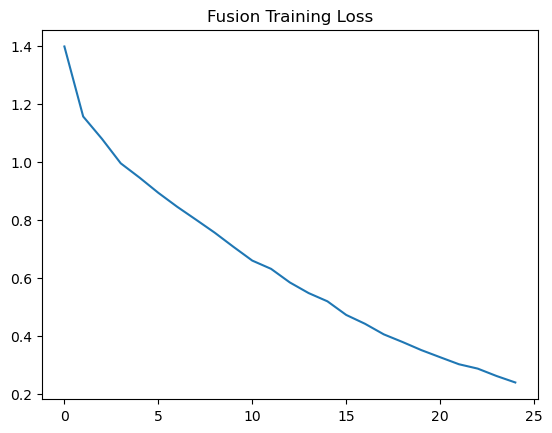

                precision    recall  f1-score   support

         No_DR       0.98      0.90      0.94       358
          Mild       0.44      0.88      0.59        90
      Moderate       0.81      0.63      0.71       197
        Severe       0.49      0.45      0.47        38
Proliferate_DR       0.71      0.54      0.61        50

      accuracy                           0.78       733
     macro avg       0.69      0.68      0.66       733
  weighted avg       0.83      0.78      0.79       733



C:\Users\Sahil\AppData\Local\Temp\ipykernel_48036\1894049065.py:574: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load("best_student_fus


Generating Grad-CAMs (CNN Branch Focus)...
Done.


In [3]:
# fusion_retinopathy_fixed.py
import os
import random
import warnings
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import classification_report
import timm

# --- TDA Import ---
try:
    import gudhi as gd
    TDA_AVAILABLE = True
except ImportError:
    TDA_AVAILABLE = False
    print("⚠ 'gudhi' library not found. TDA features will be zeros.")

warnings.filterwarnings("ignore", category=UserWarning)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# -------------------------
# Config
# -------------------------
config = {
    "csv_path": "train.csv",
    "img_root": "colored_images",
    "backbone": "efficientnet_b2",   # Student backbone
    "teacher_backbone": "efficientnet_b5", # Teacher backbone
    "num_classes": 5,
    "batch_size": 8,
    "epochs": 25,
    "lr": 1e-4,
    "use_cbam": True,
    "use_distill": True,
    "loss_fn": "CrossEntropyLoss",
    "early_stop_patience": 5,
    "gradcam_out_dir": "Fusion_TDA_EfficientNet",
    "image_size": 224,

    # Teacher Training
    "train_teacher": True,
    "teacher_epochs": 5,

    # Distillation Params
    "distill_alpha_start": 0.2,
    "distill_alpha_end": 0.8,
    "distill_temperature": 4.0,

    # Augmentation & Regularization
    "consistency_weight": 0.1,
    "use_class_weights": True,
    "label_smoothing": 0.1,
    "max_grad_norm": 5.0,
    "rotation_angles": [0, 90, 180, 270],

    # TDA Fusion Config
    "use_tda": True,
    "tda_img_size": 32,       # Size for TDA calculation (CPU intensive)
    "tda_embed_dim": 64,      # Dimension of the learned TDA feature space

    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

device = torch.device(config["device"])
if device.type == "cuda":
    print(f"✅ Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠ No GPU found. Using CPU.")

# -------------------------
# Dataset & Transforms
# -------------------------
train_transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform
        # normalize column names and pick first two columns as image and label
        self.data.columns = [c.strip().lower() for c in self.data.columns]
        self.image_col = self.data.columns[0]
        self.label_col = self.data.columns[1]
        self.folder_names = sorted([f for f in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, f))])
        self.numeric_to_folder = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}

    def __len__(self):
        return len(self.data)

    def _find_image(self, folder, img_id):
        for ext in [".png", ".jpg", ".jpeg"]:
            p = os.path.join(self.img_root, folder, f"{img_id}{ext}")
            if os.path.exists(p):
                return p
        p = os.path.join(self.img_root, folder, img_id)
        if os.path.exists(p):
            return p
        raise FileNotFoundError(f"Image {img_id} not found in folder {folder}.")

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx][self.image_col])
        label_val = self.data.iloc[idx][self.label_col]
        if isinstance(label_val, (int, float)) or str(label_val).isdigit():
            label_val = int(label_val)
            folder_name = self.numeric_to_folder.get(label_val, str(label_val))
            label_idx = label_val
        else:
            folder_name = str(label_val)
            label_idx = self.folder_names.index(folder_name) if folder_name in self.folder_names else 0

        img_path = self._find_image(folder_name, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# Load Data
dataset = None
use_imagefolder = False
if os.path.exists(config["csv_path"]) and os.path.isdir(config["img_root"]):
    try:
        dataset = RetinopathyDataset(config["csv_path"], config["img_root"], transform=train_transform)
        print("✅ Loaded CSV Dataset.")
    except Exception as e:
        print("Failed to load CSV Dataset:", e)
        dataset = None

if dataset is None:
    if os.path.isdir(config["img_root"]):
        dataset = datasets.ImageFolder(root=config["img_root"], transform=train_transform)
        use_imagefolder = True
        print("✅ Loaded ImageFolder Dataset.")
    else:
        raise FileNotFoundError("Data not found. Provide 'train.csv' and 'colored_images' or an ImageFolder structure.")

# class names
if use_imagefolder:
    class_names = dataset.classes
else:
    class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

if use_imagefolder:
    val_ds = Subset(datasets.ImageFolder(config["img_root"], transform=val_transform), val_ds.indices)
else:
    val_ds = Subset(RetinopathyDataset(config["csv_path"], config["img_root"], transform=val_transform), val_ds.indices)

# num_workers safe default (0 on Windows often)
num_workers_train = 4 if os.name != 'nt' else 0
num_workers_val = 2 if os.name != 'nt' else 0

train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True,
                          num_workers=num_workers_train, pin_memory=(device.type=="cuda"))
val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False,
                        num_workers=num_workers_val, pin_memory=(device.type=="cuda"))

# -------------------------
# TDA Extraction & Learnable Head
# -------------------------
def compute_persistence_entropy(persistence, dim):
    pts = [p[1] for p in persistence if p[0] == dim]
    if not pts:
        return 0.0, 0.0
    pts = np.array(pts)
    births, deaths = pts[:, 0], pts[:, 1]
    finite_deaths = deaths[np.isfinite(deaths)]
    max_val = np.max(finite_deaths) if finite_deaths.size > 0 else 1.0
    deaths = np.where(np.isfinite(deaths), deaths, max_val + 0.1)
    lifetimes = deaths - births
    lifetimes = lifetimes[lifetimes > 0]
    if len(lifetimes) == 0:
        return 0.0, 0.0
    sum_life = np.sum(lifetimes)
    probs = lifetimes / sum_life
    entropy = -np.sum(probs * np.log(probs + 1e-8))
    return float(entropy), float(sum_life)

def extract_tda_features_batch(images_tensor, tda_size=32):
    """ Extracts static topological features """
    if not TDA_AVAILABLE:
        return torch.zeros((images_tensor.size(0), 4), dtype=torch.float32, device=images_tensor.device)

    # Downsample for speed
    small_imgs = torch.nn.functional.interpolate(images_tensor, size=(tda_size, tda_size), mode='bilinear', align_corners=False)
    # Convert to grayscale (assuming images in [C,H,W])
    gray_imgs = 0.299 * small_imgs[:, 0, :, :] + 0.587 * small_imgs[:, 1, :, :] + 0.114 * small_imgs[:, 2, :, :]
    gray_imgs_np = gray_imgs.cpu().detach().numpy()

    batch_features = []
    for i in range(gray_imgs_np.shape[0]):
        flat = gray_imgs_np[i].astype(np.float64)
        # Gudhi expects top_dimensional_cells to be a flattened sequence
        try:
            cc = gd.CubicalComplex(dimensions=flat.shape, top_dimensional_cells=flat.flatten())
            persistence = cc.persistence()
            h0_ent, h0_sum = compute_persistence_entropy(persistence, 0) # Components
            h1_ent, h1_sum = compute_persistence_entropy(persistence, 1) # Loops
            batch_features.append([h0_ent, h0_sum, h1_ent, h1_sum])
        except Exception:
            # fallback to zeros for that instance
            batch_features.append([0.0, 0.0, 0.0, 0.0])

    return torch.tensor(batch_features, dtype=torch.float32, device=images_tensor.device)

class TDA_Learnable_Head(nn.Module):
    """ Trained TDA head projecting 4-d TDA stats into learned embedding.
        Uses LayerNorm to avoid batch-size issues when batch==1.
    """
    def __init__(self, input_dim=4, embed_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.ln1 = nn.LayerNorm(16)
        self.fc2 = nn.Linear(16, 32)
        self.ln2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, embed_dim)
        self.ln3 = nn.LayerNorm(embed_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.ln1(self.fc1(x)))
        x = self.act(self.ln2(self.fc2(x)))
        x = self.act(self.ln3(self.fc3(x)))
        return x

# -------------------------
# CBAM Block (modified to avoid BatchNorm2d issues)
# -------------------------
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_gate = nn.Sequential(
            nn.Linear(channels, max(1, channels//reduction), bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(max(1, channels//reduction), channels, bias=False)
        )
        # use GroupNorm(1, 1) for stability regardless of batch size
        self.spatial_gate = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False),
            nn.GroupNorm(1, 1)
        )

    def forward(self, x):
        b, c, h, w = x.size()
        # Channel Attention
        avg_pool = torch.mean(x, dim=(2, 3))          # shape (b, c)
        max_pool, _ = torch.max(x.view(b, c, -1), dim=2)
        c_out = torch.sigmoid(self.channel_gate(avg_pool) + self.channel_gate(max_pool)).view(b, c, 1, 1)
        x = x * c_out
        # Spatial Attention
        avg_s = torch.mean(x, dim=1, keepdim=True)
        max_s, _ = torch.max(x, dim=1, keepdim=True)
        s_out = torch.sigmoid(self.spatial_gate(torch.cat([avg_s, max_s], dim=1)))
        return x * s_out

# -------------------------
# FUSION MODEL (Student)
# -------------------------
class EfficientNetTDAFusion(nn.Module):
    def __init__(self, backbone_name, num_classes, use_cbam=True, use_tda=True, tda_embed_dim=64):
        super().__init__()

        # 1. TRAINED EFFICIENTNET BRANCH
        self.feature_extractor = timm.create_model(backbone_name, pretrained=True, features_only=True)
        cnn_out_channels = self.feature_extractor.feature_info[-1]['num_chs']

        self.use_cbam = use_cbam
        self.cbam = CBAMBlock(cnn_out_channels) if use_cbam else None

        # 2. TRAINED TDA BRANCH
        self.use_tda = use_tda
        self.tda_embed_dim = tda_embed_dim if use_tda else 0
        if self.use_tda:
            self.tda_head = TDA_Learnable_Head(input_dim=4, embed_dim=tda_embed_dim)

        # 3. FUSION & CLASSIFIER
        total_dim = cnn_out_channels + self.tda_embed_dim
        self.classifier = nn.Linear(total_dim, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if isinstance(feats, (list, tuple)):
            feats = feats[-1]
        if self.cbam:
            feats = self.cbam(feats)
        cnn_emb = nn.functional.adaptive_avg_pool2d(feats, (1, 1)).flatten(1)

        if self.use_tda:
            raw_tda = extract_tda_features_batch(x, tda_size=config["tda_img_size"])
            raw_tda = torch.log1p(raw_tda)
            tda_emb = self.tda_head(raw_tda)
            fusion_vec = torch.cat((cnn_emb, tda_emb), dim=1)
            logits = self.classifier(fusion_vec)
        else:
            logits = self.classifier(cnn_emb)

        return logits

# -------------------------
# Loss & Trainer
# -------------------------
class DistillationLoss(nn.Module):
    def __init__(self, base_loss, teacher_model=None, alpha_start=0.5, alpha_end=0.5, T=4.0):
        super().__init__()
        self.base_loss = base_loss
        self.teacher = teacher_model
        self.alpha_start, self.alpha_end, self.T = alpha_start, alpha_end, T
        self.epoch, self.max_epochs = 0, 1
        if self.teacher is not None:
            self.teacher.eval()
            for p in self.teacher.parameters():
                p.requires_grad = False

    def set_epoch(self, epoch, max_epochs):
        self.epoch = epoch
        self.max_epochs = max_epochs

    def forward(self, s_logits, inputs, labels):
        hard = self.base_loss(s_logits, labels)
        if not self.teacher:
            return hard
        with torch.no_grad():
            t_logits = self.teacher(inputs)

        alpha = self.alpha_start + (self.alpha_end - self.alpha_start) * (self.epoch / max(1, self.max_epochs - 1))
        soft = nn.KLDivLoss(reduction='batchmean')(
            nn.functional.log_softmax(s_logits / self.T, dim=1),
            nn.functional.softmax(t_logits / self.T, dim=1)
        ) * (self.T ** 2)
        return alpha * soft + (1.0 - alpha) * hard

class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device, config):
        self.model, self.criterion = model, criterion
        self.optimizer, self.scheduler = optimizer, scheduler
        self.device, self.config = device, config

    def train_epoch(self, loader, epoch_idx, total_epochs):
        self.model.train()
        running_loss, n = 0.0, 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()

            outputs = self.model(imgs)

            if isinstance(self.criterion, DistillationLoss):
                self.criterion.set_epoch(epoch_idx, total_epochs)
                loss = self.criterion(outputs, imgs, labels)
            else:
                loss = self.criterion(outputs, labels)

            # Consistency Reg
            if self.config["consistency_weight"] > 0.0:
                angle = random.choice(self.config["rotation_angles"])
                if angle % 360 != 0:
                    rot_imgs = torch.stack([transforms.functional.rotate(img.cpu(), angle) for img in imgs]).to(self.device)
                    with torch.no_grad():
                        p_orig = nn.functional.softmax(outputs, dim=1)
                    rot_out = self.model(rot_imgs)
                    loss += self.config["consistency_weight"] * nn.functional.kl_div(
                        nn.functional.log_softmax(rot_out, dim=1), p_orig, reduction='batchmean')

            loss.backward()
            if self.config["max_grad_norm"]:
                nn.utils.clip_grad_norm_(self.model.parameters(), self.config["max_grad_norm"])
            self.optimizer.step()
            if self.scheduler:
                try:
                    self.scheduler.step()
                except Exception:
                    pass

            running_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
        return running_loss / max(1, n)

    def evaluate(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                preds.extend(outputs.argmax(1).cpu().numpy().tolist())
                trues.extend(labels.numpy().tolist())
        return preds, trues

# -------------------------
# MAIN
# -------------------------
# 1. Loss & Weights
class_weights = None
if config["use_class_weights"]:
    c = np.zeros(config["num_classes"])
    for _, l in train_ds:
        c[l] += 1
    w = 1.0 / (c / c.sum() + 1e-6)
    class_weights = torch.tensor(w / w.mean(), dtype=torch.float32).to(device)
    print("Class weights:", class_weights)

base_loss = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=config["label_smoothing"])

# 2. Teacher Training
teacher_model = None
if config["use_distill"]:
    print(f"✅ Teacher: {config['teacher_backbone']}")
    teacher_model = timm.create_model(config["teacher_backbone"], pretrained=True, num_classes=config["num_classes"]).to(device)

    if config["train_teacher"]:
        print("\n🎓 Training Teacher (B5)...")
        opt = optim.AdamW(teacher_model.parameters(), lr=config["lr"])
        sch = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=config["lr"], steps_per_epoch=len(train_loader), epochs=config["teacher_epochs"])
        tt = Trainer(teacher_model, base_loss, opt, sch, device, config)

        best_loss = float("inf")
        for ep in range(config["teacher_epochs"]):
            tl = tt.train_epoch(train_loader, ep, config["teacher_epochs"])
            teacher_model.eval()
            vl, tot = 0.0, 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    vl += base_loss(teacher_model(x), y).item() * x.size(0)
                    tot += x.size(0)
            vl /= max(1, tot)
            print(f"Teacher Epoch {ep+1} - Val: {vl:.4f}")
            if vl < best_loss:
                best_loss = vl
                torch.save(teacher_model.state_dict(), "best_teacher.pth")
        if os.path.exists("best_teacher.pth"):
            teacher_model.load_state_dict(torch.load("best_teacher.pth", map_location=device))
    print("🎓 Teacher Ready.\n")

# 3. Student Fusion Model
criterion = DistillationLoss(base_loss, teacher_model,
                             config["distill_alpha_start"], config["distill_alpha_end"]) if config["use_distill"] else base_loss

student_model = EfficientNetTDAFusion(
    backbone_name=config["backbone"],
    num_classes=config["num_classes"],
    use_cbam=config["use_cbam"],
    use_tda=config["use_tda"],
    tda_embed_dim=config["tda_embed_dim"]
).to(device)

print(f"✅ Student Fusion Model Created: {config['backbone']} + Trained TDA Head")

optimizer = optim.AdamW(student_model.parameters(), lr=config["lr"])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config["lr"]*5, steps_per_epoch=len(train_loader), epochs=config["epochs"])
trainer = Trainer(student_model, criterion, optimizer, scheduler, device, config)

# 4. Training Loop
print("\n🚀 Starting Fusion Training...")
train_losses = []
best_val_loss = float("inf")
patience = 0

for epoch in range(config["epochs"]):
    t_loss = trainer.train_epoch(train_loader, epoch, config["epochs"])
    train_losses.append(t_loss)

    # Val
    student_model.eval()
    v_loss, tot = 0.0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = student_model(x)
            if isinstance(criterion, DistillationLoss):
                criterion.set_epoch(epoch, config["epochs"])
                loss = criterion(out, x, y)
            else:
                loss = criterion(out, y)
            v_loss += loss.item() * x.size(0)
            tot += x.size(0)
    v_loss /= max(1, tot)

    print(f"Epoch {epoch+1}/{config['epochs']} - Train: {t_loss:.4f} - Val: {v_loss:.4f}")

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        patience = 0
        torch.save(student_model.state_dict(), "best_student_fusion.pth")
        print("✅ Best Fusion Model Saved.")
    else:
        patience += 1
        if patience >= config["early_stop_patience"]:
            print("🛑 Early Stopping.")
            break

# 5. Evaluate
plt.plot(train_losses)
plt.title("Fusion Training Loss")
plt.show()
preds, trues = trainer.evaluate(val_loader)
print(classification_report(trues, preds, target_names=class_names))

# Grad-CAM
def get_cam(model, x, cls_idx):
    model.eval()
    last_conv = None
    for m in model.feature_extractor.modules():
        if isinstance(m, nn.Conv2d):
            last_conv = m
    if last_conv is None:
        return None

    acts, grads = {}, {}

    def f_hook(m, i, o):
        acts['v'] = o.detach()

    def b_hook(m, gi, go):
        grads['v'] = go[0].detach()

    h1 = last_conv.register_forward_hook(f_hook)
    try:
        h2 = last_conv.register_full_backward_hook(b_hook)
    except Exception:
        h2 = last_conv.register_backward_hook(b_hook)

    out = model(x)
    model.zero_grad()
    out[0, cls_idx].backward()

    if 'v' not in grads or 'v' not in acts:
        h1.remove()
        try:
            h2.remove()
        except Exception:
            pass
        return None

    w = torch.mean(grads['v'], dim=(2, 3), keepdim=True)
    cam = torch.relu(torch.sum(w * acts['v'], dim=1)).squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    h1.remove()
    try:
        h2.remove()
    except Exception:
        pass
    return cam

os.makedirs(config["gradcam_out_dir"], exist_ok=True)
if os.path.exists("best_student_fusion.pth"):
    student_model.load_state_dict(torch.load("best_student_fusion.pth", map_location=device))

print("\nGenerating Grad-CAMs (CNN Branch Focus)...")
seen_c = set()
for i in range(len(val_ds)):
    if len(seen_c) >= len(class_names):
        break
    _, lbl = val_ds[i]
    if lbl not in seen_c:
        seen_c.add(lbl)
        img, _ = val_ds[i]
        x = img.unsqueeze(0).to(device)
        cam = get_cam(student_model, x, lbl)
        if cam is not None:
            cam = cv2.resize(cam, (config["image_size"], config["image_size"]))
            heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
            orig = ((img.permute(1,2,0).cpu().numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])*255).astype(np.uint8)
            orig = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)
            out = cv2.addWeighted(orig, 0.6, heatmap, 0.4, 0)
            cv2.imwrite(f"{config['gradcam_out_dir']}/Fusion_CAM_{class_names[lbl]}.jpg", out)
print("Done.")
